In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "int99"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 288
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 360
Categorical Columns: 8


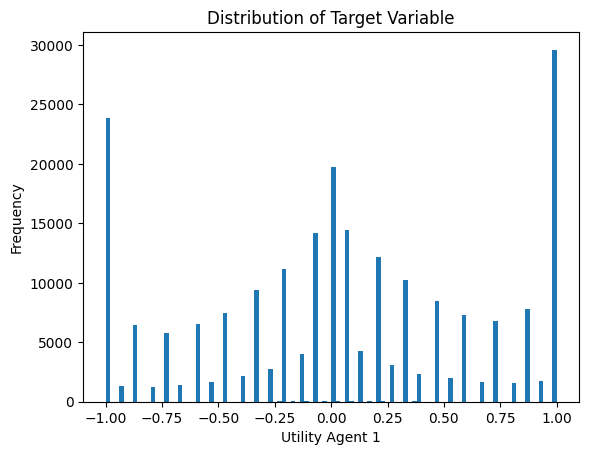

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.495269


[200]	valid_0's rmse: 0.477424


[300]	valid_0's rmse: 0.468214


[400]	valid_0's rmse: 0.461698


[500]	valid_0's rmse: 0.456787


[600]	valid_0's rmse: 0.452755


[700]	valid_0's rmse: 0.449264


[800]	valid_0's rmse: 0.44611


[900]	valid_0's rmse: 0.443472


[1000]	valid_0's rmse: 0.441385


[1100]	valid_0's rmse: 0.439702


[1200]	valid_0's rmse: 0.438561


[1300]	valid_0's rmse: 0.437388


[1400]	valid_0's rmse: 0.436538


[1500]	valid_0's rmse: 0.435738


[1600]	valid_0's rmse: 0.434911


[1700]	valid_0's rmse: 0.434279


[1800]	valid_0's rmse: 0.433642


[1900]	valid_0's rmse: 0.433


[2000]	valid_0's rmse: 0.432394


[2100]	valid_0's rmse: 0.431898


[2200]	valid_0's rmse: 0.431494


[2300]	valid_0's rmse: 0.431137


[2400]	valid_0's rmse: 0.430742


[2500]	valid_0's rmse: 0.430352


[2600]	valid_0's rmse: 0.430071


[2700]	valid_0's rmse: 0.429664


[2800]	valid_0's rmse: 0.429418


[2900]	valid_0's rmse: 0.429162


[3000]	valid_0's rmse: 0.428901


[3100]	valid_0's rmse: 0.428631


[3200]	valid_0's rmse: 0.428413


[3300]	valid_0's rmse: 0.428258


[3400]	valid_0's rmse: 0.428059


[3500]	valid_0's rmse: 0.427834


[3600]	valid_0's rmse: 0.427657


[3700]	valid_0's rmse: 0.427408


[3800]	valid_0's rmse: 0.427203


[3900]	valid_0's rmse: 0.427097


[4000]	valid_0's rmse: 0.426886


[4100]	valid_0's rmse: 0.426699


[4200]	valid_0's rmse: 0.426523


[4300]	valid_0's rmse: 0.426294


[4400]	valid_0's rmse: 0.426255


[4500]	valid_0's rmse: 0.426161


[4600]	valid_0's rmse: 0.426119


[4700]	valid_0's rmse: 0.426026


[4800]	valid_0's rmse: 0.425811


[4900]	valid_0's rmse: 0.425712


[5000]	valid_0's rmse: 0.42568


[5100]	valid_0's rmse: 0.425504


[5200]	valid_0's rmse: 0.425472


[5300]	valid_0's rmse: 0.425456


[5400]	valid_0's rmse: 0.425321


[5500]	valid_0's rmse: 0.425193


[5600]	valid_0's rmse: 0.42508


[5700]	valid_0's rmse: 0.425057


[5800]	valid_0's rmse: 0.425013


[5900]	valid_0's rmse: 0.424967


[6000]	valid_0's rmse: 0.424953


[6100]	valid_0's rmse: 0.424894


[6200]	valid_0's rmse: 0.424838


[6300]	valid_0's rmse: 0.424776


[6400]	valid_0's rmse: 0.424666


[6500]	valid_0's rmse: 0.424636


[6600]	valid_0's rmse: 0.424611


[6700]	valid_0's rmse: 0.424544


[6800]	valid_0's rmse: 0.424451


[6900]	valid_0's rmse: 0.424449


[7000]	valid_0's rmse: 0.424333


[7100]	valid_0's rmse: 0.424331


[7200]	valid_0's rmse: 0.424346


[7300]	valid_0's rmse: 0.424362


[7400]	valid_0's rmse: 0.42432


[7500]	valid_0's rmse: 0.424324


[7600]	valid_0's rmse: 0.424349


[7700]	valid_0's rmse: 0.424288


[7800]	valid_0's rmse: 0.4243


[7900]	valid_0's rmse: 0.4243


[8000]	valid_0's rmse: 0.42429


[8100]	valid_0's rmse: 0.424308


[8200]	valid_0's rmse: 0.424327


[8300]	valid_0's rmse: 0.424408


[8400]	valid_0's rmse: 0.424384


[8500]	valid_0's rmse: 0.424379


[8600]	valid_0's rmse: 0.424386


[8700]	valid_0's rmse: 0.424341


[8800]	valid_0's rmse: 0.424312


[8900]	valid_0's rmse: 0.424319


[9000]	valid_0's rmse: 0.424317


[9100]	valid_0's rmse: 0.424276


[9200]	valid_0's rmse: 0.424237


[9300]	valid_0's rmse: 0.424248


[9400]	valid_0's rmse: 0.424231


[9500]	valid_0's rmse: 0.424308


[9600]	valid_0's rmse: 0.424375


[9700]	valid_0's rmse: 0.424366


[9800]	valid_0's rmse: 0.424366


[9900]	valid_0's rmse: 0.424365


[10000]	valid_0's rmse: 0.424342


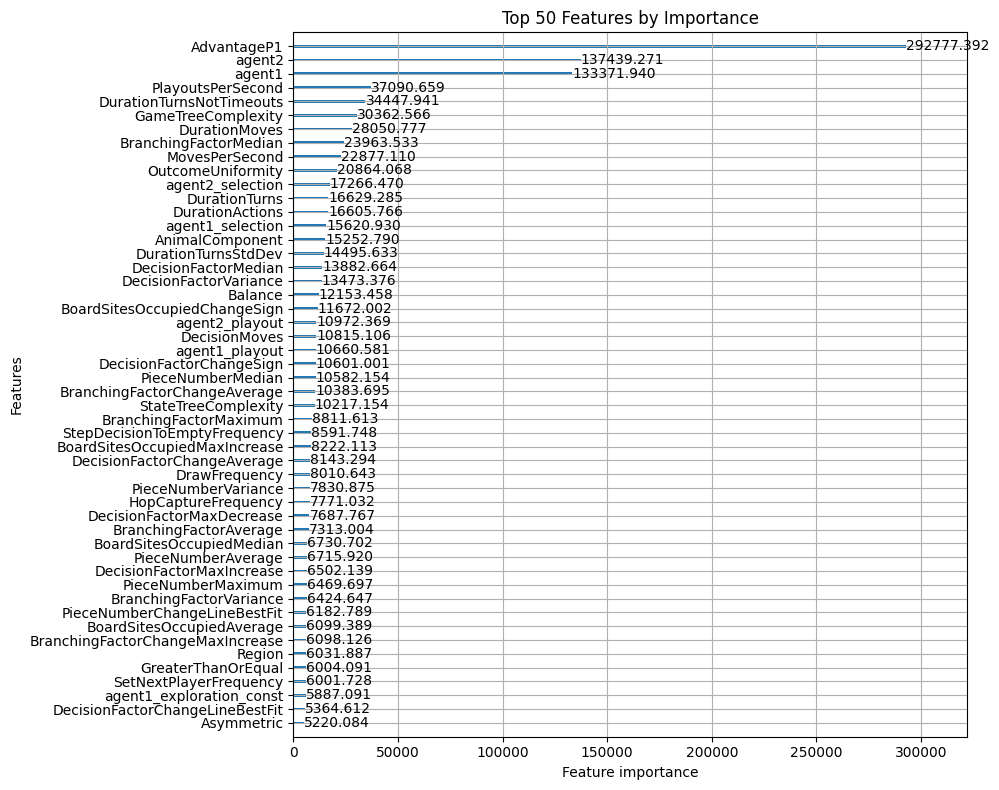

Fold 1 - RMSE: 0.4238004666497874
Fold 2


[100]	valid_0's rmse: 0.508766


[200]	valid_0's rmse: 0.492218


[300]	valid_0's rmse: 0.485129


[400]	valid_0's rmse: 0.479541


[500]	valid_0's rmse: 0.47607


[600]	valid_0's rmse: 0.47277


[700]	valid_0's rmse: 0.471366


[800]	valid_0's rmse: 0.469533


[900]	valid_0's rmse: 0.467984


[1000]	valid_0's rmse: 0.466431


[1100]	valid_0's rmse: 0.465471


[1200]	valid_0's rmse: 0.464291


[1300]	valid_0's rmse: 0.463484


[1400]	valid_0's rmse: 0.46245


[1500]	valid_0's rmse: 0.461906


[1600]	valid_0's rmse: 0.461491


[1700]	valid_0's rmse: 0.461008


[1800]	valid_0's rmse: 0.460508


[1900]	valid_0's rmse: 0.460219


[2000]	valid_0's rmse: 0.459735


[2100]	valid_0's rmse: 0.459427


[2200]	valid_0's rmse: 0.459202


[2300]	valid_0's rmse: 0.458695


[2400]	valid_0's rmse: 0.458286


[2500]	valid_0's rmse: 0.458069


[2600]	valid_0's rmse: 0.457866


[2700]	valid_0's rmse: 0.457594


[2800]	valid_0's rmse: 0.457358


[2900]	valid_0's rmse: 0.45692


[3000]	valid_0's rmse: 0.456663


[3100]	valid_0's rmse: 0.456566


[3200]	valid_0's rmse: 0.456482


[3300]	valid_0's rmse: 0.456277


[3400]	valid_0's rmse: 0.45606


[3500]	valid_0's rmse: 0.455807


[3600]	valid_0's rmse: 0.455451


[3700]	valid_0's rmse: 0.45539


[3800]	valid_0's rmse: 0.455327


[3900]	valid_0's rmse: 0.455232


[4000]	valid_0's rmse: 0.455054


[4100]	valid_0's rmse: 0.454946


[4200]	valid_0's rmse: 0.454875


[4300]	valid_0's rmse: 0.454761


[4400]	valid_0's rmse: 0.454716


[4500]	valid_0's rmse: 0.454659


[4600]	valid_0's rmse: 0.454698


[4700]	valid_0's rmse: 0.454598


[4800]	valid_0's rmse: 0.454509


[4900]	valid_0's rmse: 0.454424


[5000]	valid_0's rmse: 0.454333


[5100]	valid_0's rmse: 0.454235


[5200]	valid_0's rmse: 0.454104


[5300]	valid_0's rmse: 0.453951


[5400]	valid_0's rmse: 0.453865


[5500]	valid_0's rmse: 0.45378


[5600]	valid_0's rmse: 0.453742


[5700]	valid_0's rmse: 0.453645


[5800]	valid_0's rmse: 0.453538


[5900]	valid_0's rmse: 0.453442


[6000]	valid_0's rmse: 0.453304


[6100]	valid_0's rmse: 0.45315


[6200]	valid_0's rmse: 0.453089


[6300]	valid_0's rmse: 0.45303


[6400]	valid_0's rmse: 0.45285


[6500]	valid_0's rmse: 0.452775


[6600]	valid_0's rmse: 0.452719


[6700]	valid_0's rmse: 0.452752


[6800]	valid_0's rmse: 0.452682


[6900]	valid_0's rmse: 0.452601


[7000]	valid_0's rmse: 0.452546


[7100]	valid_0's rmse: 0.45256


[7200]	valid_0's rmse: 0.452588


[7300]	valid_0's rmse: 0.452487


[7400]	valid_0's rmse: 0.452487


[7500]	valid_0's rmse: 0.452431


[7600]	valid_0's rmse: 0.452404


[7700]	valid_0's rmse: 0.452398


[7800]	valid_0's rmse: 0.452281


[7900]	valid_0's rmse: 0.452223


[8000]	valid_0's rmse: 0.452224


[8100]	valid_0's rmse: 0.452199


[8200]	valid_0's rmse: 0.452129


[8300]	valid_0's rmse: 0.452134


[8400]	valid_0's rmse: 0.452012


[8500]	valid_0's rmse: 0.451963


[8600]	valid_0's rmse: 0.451939


[8700]	valid_0's rmse: 0.451894


[8800]	valid_0's rmse: 0.451908


[8900]	valid_0's rmse: 0.451902


[9000]	valid_0's rmse: 0.451892


[9100]	valid_0's rmse: 0.451863


[9200]	valid_0's rmse: 0.451873


[9300]	valid_0's rmse: 0.451899


[9400]	valid_0's rmse: 0.451907


[9500]	valid_0's rmse: 0.451903


[9600]	valid_0's rmse: 0.451834


[9700]	valid_0's rmse: 0.451822


[9800]	valid_0's rmse: 0.451764


[9900]	valid_0's rmse: 0.451829


[10000]	valid_0's rmse: 0.451821


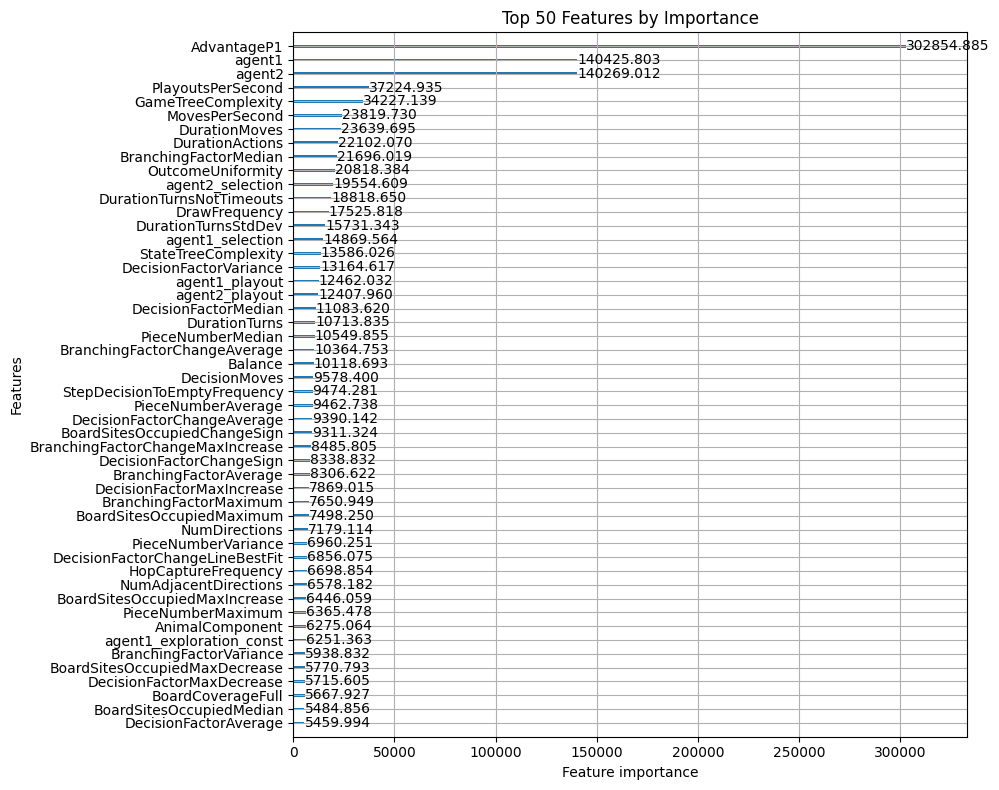

Fold 2 - RMSE: 0.4510773791884074
Fold 3


[100]	valid_0's rmse: 0.515154


[200]	valid_0's rmse: 0.486749


[300]	valid_0's rmse: 0.475888


[400]	valid_0's rmse: 0.468559


[500]	valid_0's rmse: 0.464488


[600]	valid_0's rmse: 0.461784


[700]	valid_0's rmse: 0.459472


[800]	valid_0's rmse: 0.457362


[900]	valid_0's rmse: 0.455064


[1000]	valid_0's rmse: 0.45342


[1100]	valid_0's rmse: 0.452184


[1200]	valid_0's rmse: 0.451126


[1300]	valid_0's rmse: 0.450113


[1400]	valid_0's rmse: 0.449203


[1500]	valid_0's rmse: 0.448282


[1600]	valid_0's rmse: 0.447637


[1700]	valid_0's rmse: 0.447043


[1800]	valid_0's rmse: 0.446672


[1900]	valid_0's rmse: 0.445979


[2000]	valid_0's rmse: 0.445574


[2100]	valid_0's rmse: 0.445115


[2200]	valid_0's rmse: 0.444772


[2300]	valid_0's rmse: 0.444244


[2400]	valid_0's rmse: 0.443975


[2500]	valid_0's rmse: 0.443781


[2600]	valid_0's rmse: 0.443516


[2700]	valid_0's rmse: 0.443225


[2800]	valid_0's rmse: 0.44296


[2900]	valid_0's rmse: 0.442699


[3000]	valid_0's rmse: 0.442462


[3100]	valid_0's rmse: 0.442311


[3200]	valid_0's rmse: 0.442072


[3300]	valid_0's rmse: 0.441849


[3400]	valid_0's rmse: 0.441733


[3500]	valid_0's rmse: 0.441561


[3600]	valid_0's rmse: 0.441351


[3700]	valid_0's rmse: 0.441198


[3800]	valid_0's rmse: 0.440931


[3900]	valid_0's rmse: 0.440846


[4000]	valid_0's rmse: 0.44065


[4100]	valid_0's rmse: 0.440543


[4200]	valid_0's rmse: 0.440408


[4300]	valid_0's rmse: 0.440269


[4400]	valid_0's rmse: 0.440172


[4500]	valid_0's rmse: 0.440121


[4600]	valid_0's rmse: 0.44007


[4700]	valid_0's rmse: 0.439969


[4800]	valid_0's rmse: 0.439896


[4900]	valid_0's rmse: 0.439796


[5000]	valid_0's rmse: 0.439806


[5100]	valid_0's rmse: 0.439722


[5200]	valid_0's rmse: 0.439595


[5300]	valid_0's rmse: 0.439526


[5400]	valid_0's rmse: 0.439453


[5500]	valid_0's rmse: 0.439351


[5600]	valid_0's rmse: 0.439283


[5700]	valid_0's rmse: 0.439179


[5800]	valid_0's rmse: 0.439068


[5900]	valid_0's rmse: 0.439003


[6000]	valid_0's rmse: 0.438957


[6100]	valid_0's rmse: 0.438921


[6200]	valid_0's rmse: 0.438828


[6300]	valid_0's rmse: 0.43879


[6400]	valid_0's rmse: 0.438787


[6500]	valid_0's rmse: 0.438776


[6600]	valid_0's rmse: 0.438747


[6700]	valid_0's rmse: 0.438673


[6800]	valid_0's rmse: 0.438627


[6900]	valid_0's rmse: 0.438567


[7000]	valid_0's rmse: 0.438573


[7100]	valid_0's rmse: 0.438488


[7200]	valid_0's rmse: 0.43849


[7300]	valid_0's rmse: 0.438438


[7400]	valid_0's rmse: 0.438469


[7500]	valid_0's rmse: 0.438407


[7600]	valid_0's rmse: 0.438391


[7700]	valid_0's rmse: 0.438356


[7800]	valid_0's rmse: 0.438302


[7900]	valid_0's rmse: 0.438327


[8000]	valid_0's rmse: 0.438324


[8100]	valid_0's rmse: 0.438282


[8200]	valid_0's rmse: 0.438273


[8300]	valid_0's rmse: 0.438225


[8400]	valid_0's rmse: 0.438189


[8500]	valid_0's rmse: 0.438174


[8600]	valid_0's rmse: 0.438086


[8700]	valid_0's rmse: 0.438058


[8800]	valid_0's rmse: 0.437991


[8900]	valid_0's rmse: 0.438002


[9000]	valid_0's rmse: 0.437951


[9100]	valid_0's rmse: 0.437981


[9200]	valid_0's rmse: 0.437967


[9300]	valid_0's rmse: 0.437973


[9400]	valid_0's rmse: 0.437969


[9500]	valid_0's rmse: 0.437948


[9600]	valid_0's rmse: 0.437947


[9700]	valid_0's rmse: 0.437883


[9800]	valid_0's rmse: 0.437848


[9900]	valid_0's rmse: 0.437873


[10000]	valid_0's rmse: 0.437875


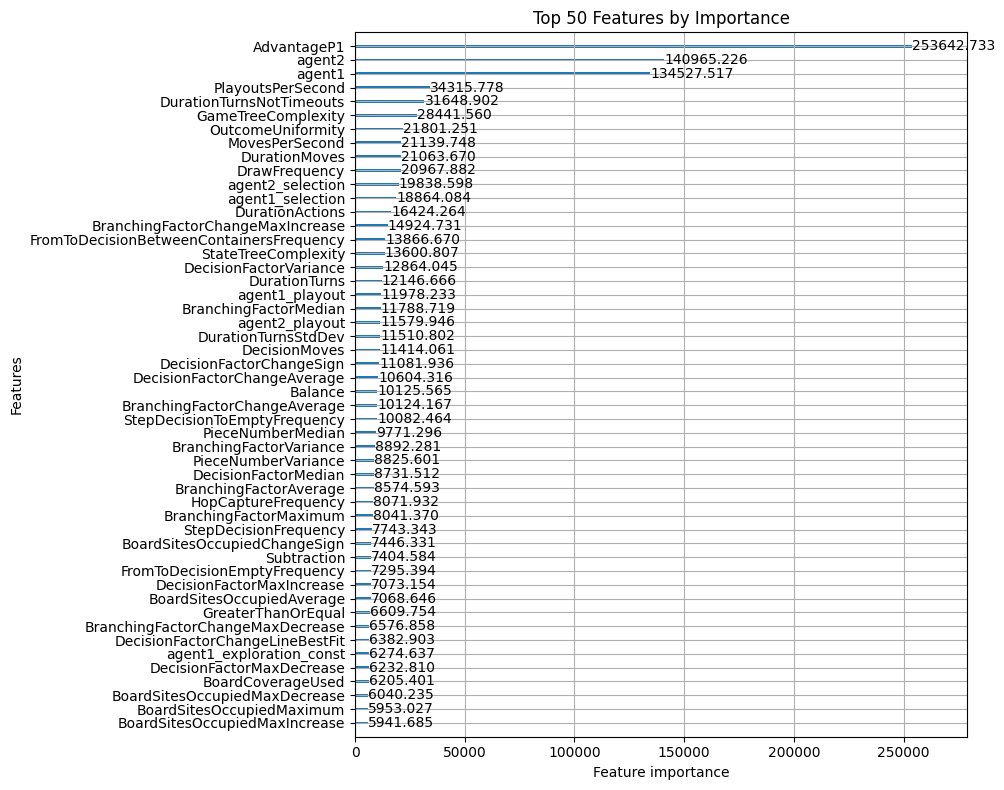

Fold 3 - RMSE: 0.43720980377022756
Fold 4


[100]	valid_0's rmse: 0.517119


[200]	valid_0's rmse: 0.493832


[300]	valid_0's rmse: 0.482526


[400]	valid_0's rmse: 0.473466


[500]	valid_0's rmse: 0.467316


[600]	valid_0's rmse: 0.462902


[700]	valid_0's rmse: 0.460111


[800]	valid_0's rmse: 0.457618


[900]	valid_0's rmse: 0.455718


[1000]	valid_0's rmse: 0.453999


[1100]	valid_0's rmse: 0.45235


[1200]	valid_0's rmse: 0.451151


[1300]	valid_0's rmse: 0.450337


[1400]	valid_0's rmse: 0.449634


[1500]	valid_0's rmse: 0.448817


[1600]	valid_0's rmse: 0.448127


[1700]	valid_0's rmse: 0.447496


[1800]	valid_0's rmse: 0.446897


[1900]	valid_0's rmse: 0.446326


[2000]	valid_0's rmse: 0.44592


[2100]	valid_0's rmse: 0.445487


[2200]	valid_0's rmse: 0.445147


[2300]	valid_0's rmse: 0.444642


[2400]	valid_0's rmse: 0.444148


[2500]	valid_0's rmse: 0.443863


[2600]	valid_0's rmse: 0.443513


[2700]	valid_0's rmse: 0.442983


[2800]	valid_0's rmse: 0.442628


[2900]	valid_0's rmse: 0.442396


[3000]	valid_0's rmse: 0.442251


[3100]	valid_0's rmse: 0.442052


[3200]	valid_0's rmse: 0.441817


[3300]	valid_0's rmse: 0.441594


[3400]	valid_0's rmse: 0.441408


[3500]	valid_0's rmse: 0.441222


[3600]	valid_0's rmse: 0.441081


[3700]	valid_0's rmse: 0.440917


[3800]	valid_0's rmse: 0.440799


[3900]	valid_0's rmse: 0.440617


[4000]	valid_0's rmse: 0.440557


[4100]	valid_0's rmse: 0.44042


[4200]	valid_0's rmse: 0.440284


[4300]	valid_0's rmse: 0.440066


[4400]	valid_0's rmse: 0.43998


[4500]	valid_0's rmse: 0.439864


[4600]	valid_0's rmse: 0.439704


[4700]	valid_0's rmse: 0.439601


[4800]	valid_0's rmse: 0.439487


[4900]	valid_0's rmse: 0.439312


[5000]	valid_0's rmse: 0.439238


[5100]	valid_0's rmse: 0.439103


[5200]	valid_0's rmse: 0.439086


[5300]	valid_0's rmse: 0.439033


[5400]	valid_0's rmse: 0.438934


[5500]	valid_0's rmse: 0.438913


[5600]	valid_0's rmse: 0.438836


[5700]	valid_0's rmse: 0.438736


[5800]	valid_0's rmse: 0.438663


[5900]	valid_0's rmse: 0.438556


[6000]	valid_0's rmse: 0.438418


[6100]	valid_0's rmse: 0.438341


[6200]	valid_0's rmse: 0.438204


[6300]	valid_0's rmse: 0.438171


[6400]	valid_0's rmse: 0.438124


[6500]	valid_0's rmse: 0.438078


[6600]	valid_0's rmse: 0.438


[6700]	valid_0's rmse: 0.43799


[6800]	valid_0's rmse: 0.437888


[6900]	valid_0's rmse: 0.437923


[7000]	valid_0's rmse: 0.437866


[7100]	valid_0's rmse: 0.437795


[7200]	valid_0's rmse: 0.437734


[7300]	valid_0's rmse: 0.437686


[7400]	valid_0's rmse: 0.437662


[7500]	valid_0's rmse: 0.437658


[7600]	valid_0's rmse: 0.437666


[7700]	valid_0's rmse: 0.437612


[7800]	valid_0's rmse: 0.437542


[7900]	valid_0's rmse: 0.437478


[8000]	valid_0's rmse: 0.43745


[8100]	valid_0's rmse: 0.437424


[8200]	valid_0's rmse: 0.437379


[8300]	valid_0's rmse: 0.437366


[8400]	valid_0's rmse: 0.437362


[8500]	valid_0's rmse: 0.437299


[8600]	valid_0's rmse: 0.437291


[8700]	valid_0's rmse: 0.437238


[8800]	valid_0's rmse: 0.437195


[8900]	valid_0's rmse: 0.437177


[9000]	valid_0's rmse: 0.437161


[9100]	valid_0's rmse: 0.437086


[9200]	valid_0's rmse: 0.437077


[9300]	valid_0's rmse: 0.437024


[9400]	valid_0's rmse: 0.436998


[9500]	valid_0's rmse: 0.436889


[9600]	valid_0's rmse: 0.436873


[9700]	valid_0's rmse: 0.436868


[9800]	valid_0's rmse: 0.436799


[9900]	valid_0's rmse: 0.436824


[10000]	valid_0's rmse: 0.436788


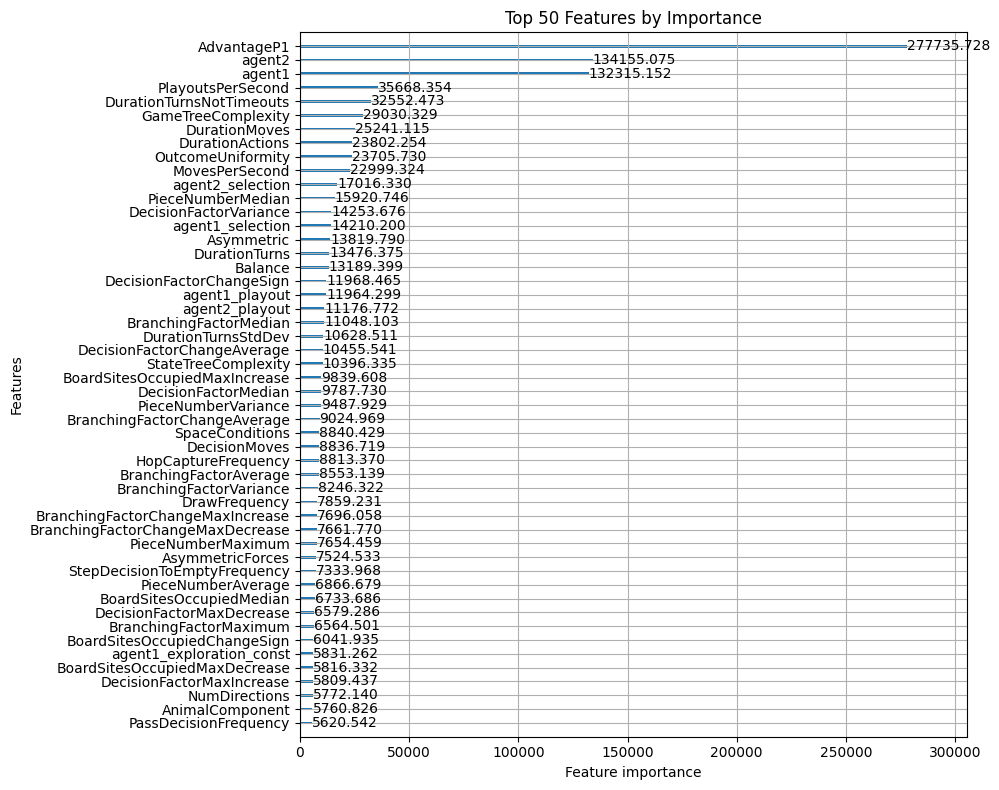

Fold 4 - RMSE: 0.4358405420335736
Fold 5


[100]	valid_0's rmse: 0.486836


[200]	valid_0's rmse: 0.465656


[300]	valid_0's rmse: 0.453546


[400]	valid_0's rmse: 0.445629


[500]	valid_0's rmse: 0.439942


[600]	valid_0's rmse: 0.436179


[700]	valid_0's rmse: 0.43348


[800]	valid_0's rmse: 0.430603


[900]	valid_0's rmse: 0.428405


[1000]	valid_0's rmse: 0.42678


[1100]	valid_0's rmse: 0.424783


[1200]	valid_0's rmse: 0.423212


[1300]	valid_0's rmse: 0.421991


[1400]	valid_0's rmse: 0.420692


[1500]	valid_0's rmse: 0.419728


[1600]	valid_0's rmse: 0.418763


[1700]	valid_0's rmse: 0.417868


[1800]	valid_0's rmse: 0.417091


[1900]	valid_0's rmse: 0.416292


[2000]	valid_0's rmse: 0.415781


[2100]	valid_0's rmse: 0.415197


[2200]	valid_0's rmse: 0.41454


[2300]	valid_0's rmse: 0.414085


[2400]	valid_0's rmse: 0.413591


[2500]	valid_0's rmse: 0.413221


[2600]	valid_0's rmse: 0.412802


[2700]	valid_0's rmse: 0.412476


[2800]	valid_0's rmse: 0.412191


[2900]	valid_0's rmse: 0.41196


[3000]	valid_0's rmse: 0.411771


[3100]	valid_0's rmse: 0.411541


[3200]	valid_0's rmse: 0.411321


[3300]	valid_0's rmse: 0.41111


[3400]	valid_0's rmse: 0.4108


[3500]	valid_0's rmse: 0.410492


[3600]	valid_0's rmse: 0.410301


[3700]	valid_0's rmse: 0.410185


[3800]	valid_0's rmse: 0.40989


[3900]	valid_0's rmse: 0.40977


[4000]	valid_0's rmse: 0.409719


[4100]	valid_0's rmse: 0.409681


[4200]	valid_0's rmse: 0.409466


[4300]	valid_0's rmse: 0.409404


[4400]	valid_0's rmse: 0.409204


[4500]	valid_0's rmse: 0.40914


[4600]	valid_0's rmse: 0.409062


[4700]	valid_0's rmse: 0.408908


[4800]	valid_0's rmse: 0.40873


[4900]	valid_0's rmse: 0.408541


[5000]	valid_0's rmse: 0.408459


[5100]	valid_0's rmse: 0.408265


[5200]	valid_0's rmse: 0.408158


[5300]	valid_0's rmse: 0.408104


[5400]	valid_0's rmse: 0.407968


[5500]	valid_0's rmse: 0.407942


[5600]	valid_0's rmse: 0.407845


[5700]	valid_0's rmse: 0.407832


[5800]	valid_0's rmse: 0.407728


[5900]	valid_0's rmse: 0.407758


[6000]	valid_0's rmse: 0.407688


[6100]	valid_0's rmse: 0.407614


[6200]	valid_0's rmse: 0.407525


[6300]	valid_0's rmse: 0.407468


[6400]	valid_0's rmse: 0.407516


[6500]	valid_0's rmse: 0.40743


[6600]	valid_0's rmse: 0.40735


[6700]	valid_0's rmse: 0.407336


[6800]	valid_0's rmse: 0.407339


[6900]	valid_0's rmse: 0.407417


[7000]	valid_0's rmse: 0.407324


[7100]	valid_0's rmse: 0.407244


[7200]	valid_0's rmse: 0.407193


[7300]	valid_0's rmse: 0.407083


[7400]	valid_0's rmse: 0.407002


[7500]	valid_0's rmse: 0.40689


[7600]	valid_0's rmse: 0.406865


[7700]	valid_0's rmse: 0.406854


[7800]	valid_0's rmse: 0.406869


[7900]	valid_0's rmse: 0.406862


[8000]	valid_0's rmse: 0.406829


[8100]	valid_0's rmse: 0.406807


[8200]	valid_0's rmse: 0.406866


[8300]	valid_0's rmse: 0.406917


[8400]	valid_0's rmse: 0.406914


[8500]	valid_0's rmse: 0.406878


[8600]	valid_0's rmse: 0.40686


[8700]	valid_0's rmse: 0.406758


[8800]	valid_0's rmse: 0.406823


[8900]	valid_0's rmse: 0.406816


[9000]	valid_0's rmse: 0.406857


[9100]	valid_0's rmse: 0.406821


[9200]	valid_0's rmse: 0.406767


[9300]	valid_0's rmse: 0.40677


[9400]	valid_0's rmse: 0.406772


[9500]	valid_0's rmse: 0.406811


[9600]	valid_0's rmse: 0.406809


[9700]	valid_0's rmse: 0.406751


[9800]	valid_0's rmse: 0.406708


[9900]	valid_0's rmse: 0.4067


[10000]	valid_0's rmse: 0.40673


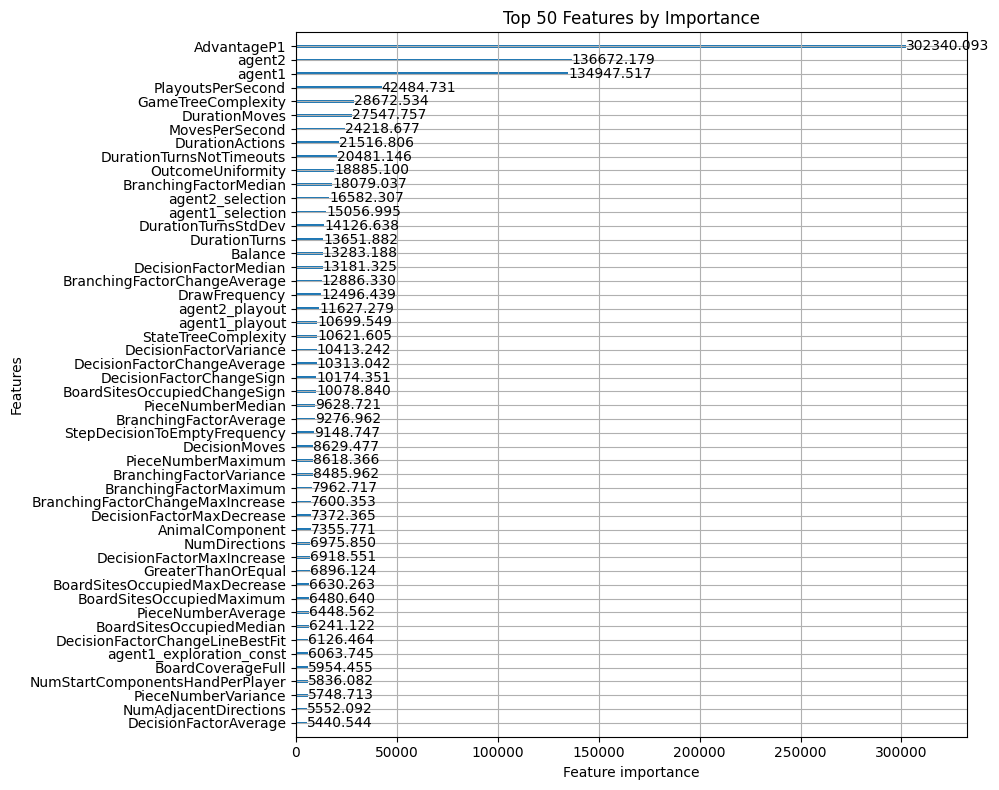

Fold 5 - RMSE: 0.40635008564295555
List of oof scores: [0.4238004666497874, 0.4510773791884074, 0.43720980377022756, 0.4358405420335736, 0.40635008564295555]
Average oof score: 0.4308556554569902


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.477503


[200]	valid_0's rmse: 0.45738


[300]	valid_0's rmse: 0.447953


[400]	valid_0's rmse: 0.442208


[500]	valid_0's rmse: 0.438638


[600]	valid_0's rmse: 0.43578


[700]	valid_0's rmse: 0.433989


[800]	valid_0's rmse: 0.432329


[900]	valid_0's rmse: 0.430411


[1000]	valid_0's rmse: 0.429043


[1100]	valid_0's rmse: 0.427664


[1200]	valid_0's rmse: 0.426544


[1300]	valid_0's rmse: 0.425734


[1400]	valid_0's rmse: 0.425167


[1500]	valid_0's rmse: 0.424472


[1600]	valid_0's rmse: 0.423802


[1700]	valid_0's rmse: 0.423218


[1800]	valid_0's rmse: 0.422623


[1900]	valid_0's rmse: 0.422208


[2000]	valid_0's rmse: 0.42174


[2100]	valid_0's rmse: 0.421332


[2200]	valid_0's rmse: 0.42086


[2300]	valid_0's rmse: 0.420457


[2400]	valid_0's rmse: 0.420197


[2500]	valid_0's rmse: 0.419959


[2600]	valid_0's rmse: 0.419751


[2700]	valid_0's rmse: 0.419427


[2800]	valid_0's rmse: 0.419145


[2900]	valid_0's rmse: 0.418946


[3000]	valid_0's rmse: 0.418792


[3100]	valid_0's rmse: 0.418679


[3200]	valid_0's rmse: 0.418416


[3300]	valid_0's rmse: 0.418247


[3400]	valid_0's rmse: 0.418068


[3500]	valid_0's rmse: 0.417833


[3600]	valid_0's rmse: 0.417687


[3700]	valid_0's rmse: 0.417619


[3800]	valid_0's rmse: 0.417325


[3900]	valid_0's rmse: 0.417155


[4000]	valid_0's rmse: 0.417045


[4100]	valid_0's rmse: 0.416901


[4200]	valid_0's rmse: 0.416743


[4300]	valid_0's rmse: 0.416668


[4400]	valid_0's rmse: 0.416555


[4500]	valid_0's rmse: 0.416433


[4600]	valid_0's rmse: 0.416379


[4700]	valid_0's rmse: 0.416258


[4800]	valid_0's rmse: 0.416166


[4900]	valid_0's rmse: 0.416074


[5000]	valid_0's rmse: 0.415952


[5100]	valid_0's rmse: 0.415806


[5200]	valid_0's rmse: 0.415761


[5300]	valid_0's rmse: 0.415661


[5400]	valid_0's rmse: 0.415587


[5500]	valid_0's rmse: 0.415472


[5600]	valid_0's rmse: 0.415393


[5700]	valid_0's rmse: 0.415315


[5800]	valid_0's rmse: 0.415301


[5900]	valid_0's rmse: 0.415316


[6000]	valid_0's rmse: 0.415296


[6100]	valid_0's rmse: 0.415219


[6200]	valid_0's rmse: 0.415188


[6300]	valid_0's rmse: 0.415169


[6400]	valid_0's rmse: 0.415143


[6500]	valid_0's rmse: 0.415078


[6600]	valid_0's rmse: 0.415041


[6700]	valid_0's rmse: 0.414967


[6800]	valid_0's rmse: 0.414937


[6900]	valid_0's rmse: 0.4149


[7000]	valid_0's rmse: 0.41487


[7100]	valid_0's rmse: 0.414838


[7200]	valid_0's rmse: 0.414815


[7300]	valid_0's rmse: 0.414812


[7400]	valid_0's rmse: 0.414752


[7500]	valid_0's rmse: 0.41472


[7600]	valid_0's rmse: 0.414685


[7700]	valid_0's rmse: 0.414625


[7800]	valid_0's rmse: 0.414622


[7900]	valid_0's rmse: 0.414533


[8000]	valid_0's rmse: 0.414472


[8100]	valid_0's rmse: 0.414451


[8200]	valid_0's rmse: 0.414451


[8300]	valid_0's rmse: 0.414435


[8400]	valid_0's rmse: 0.414406


[8500]	valid_0's rmse: 0.414369


[8600]	valid_0's rmse: 0.414345


[8700]	valid_0's rmse: 0.414279


[8800]	valid_0's rmse: 0.414253


[8900]	valid_0's rmse: 0.414208


[9000]	valid_0's rmse: 0.414184


[9100]	valid_0's rmse: 0.414203


[9200]	valid_0's rmse: 0.414181


[9300]	valid_0's rmse: 0.414155


[9400]	valid_0's rmse: 0.414104


[9500]	valid_0's rmse: 0.414063


[9600]	valid_0's rmse: 0.414043


[9700]	valid_0's rmse: 0.413967


[9800]	valid_0's rmse: 0.413926


[9900]	valid_0's rmse: 0.413893


[10000]	valid_0's rmse: 0.41389


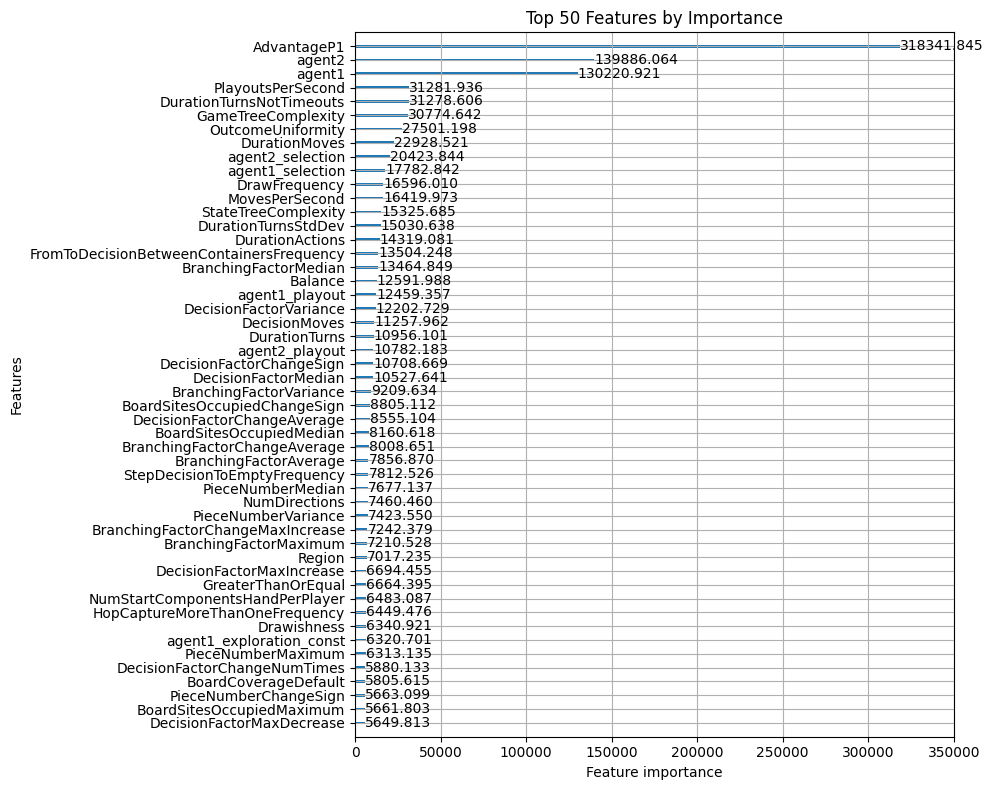

Fold 1 - RMSE: 0.4134303290569066
Fold 2


[100]	valid_0's rmse: 0.461459


[200]	valid_0's rmse: 0.440217


[300]	valid_0's rmse: 0.431244


[400]	valid_0's rmse: 0.426017


[500]	valid_0's rmse: 0.422989


[600]	valid_0's rmse: 0.420944


[700]	valid_0's rmse: 0.419225


[800]	valid_0's rmse: 0.417531


[900]	valid_0's rmse: 0.416048


[1000]	valid_0's rmse: 0.415035


[1100]	valid_0's rmse: 0.414021


[1200]	valid_0's rmse: 0.413263


[1300]	valid_0's rmse: 0.412313


[1400]	valid_0's rmse: 0.411489


[1500]	valid_0's rmse: 0.410873


[1600]	valid_0's rmse: 0.410273


[1700]	valid_0's rmse: 0.409956


[1800]	valid_0's rmse: 0.409463


[1900]	valid_0's rmse: 0.409223


[2000]	valid_0's rmse: 0.408843


[2100]	valid_0's rmse: 0.40861


[2200]	valid_0's rmse: 0.408411


[2300]	valid_0's rmse: 0.408312


[2400]	valid_0's rmse: 0.408148


[2500]	valid_0's rmse: 0.407971


[2600]	valid_0's rmse: 0.407746


[2700]	valid_0's rmse: 0.407516


[2800]	valid_0's rmse: 0.407317


[2900]	valid_0's rmse: 0.407231


[3000]	valid_0's rmse: 0.407061


[3100]	valid_0's rmse: 0.406874


[3200]	valid_0's rmse: 0.406745


[3300]	valid_0's rmse: 0.406671


[3400]	valid_0's rmse: 0.406614


[3500]	valid_0's rmse: 0.406554


[3600]	valid_0's rmse: 0.406538


[3700]	valid_0's rmse: 0.406535


[3800]	valid_0's rmse: 0.406437


[3900]	valid_0's rmse: 0.406335


[4000]	valid_0's rmse: 0.406267


[4100]	valid_0's rmse: 0.406287


[4200]	valid_0's rmse: 0.406179


[4300]	valid_0's rmse: 0.406231


[4400]	valid_0's rmse: 0.40618


[4500]	valid_0's rmse: 0.406054


[4600]	valid_0's rmse: 0.405962


[4700]	valid_0's rmse: 0.405874


[4800]	valid_0's rmse: 0.405766


[4900]	valid_0's rmse: 0.405784


[5000]	valid_0's rmse: 0.405684


[5100]	valid_0's rmse: 0.405668


[5200]	valid_0's rmse: 0.405669


[5300]	valid_0's rmse: 0.405541


[5400]	valid_0's rmse: 0.405433


[5500]	valid_0's rmse: 0.405451


[5600]	valid_0's rmse: 0.405423


[5700]	valid_0's rmse: 0.405461


[5800]	valid_0's rmse: 0.405474


[5900]	valid_0's rmse: 0.405478


[6000]	valid_0's rmse: 0.405453


[6100]	valid_0's rmse: 0.40542


[6200]	valid_0's rmse: 0.405324


[6300]	valid_0's rmse: 0.405334


[6400]	valid_0's rmse: 0.40535


[6500]	valid_0's rmse: 0.405313


[6600]	valid_0's rmse: 0.405321


[6700]	valid_0's rmse: 0.40527


[6800]	valid_0's rmse: 0.405236


[6900]	valid_0's rmse: 0.405197


[7000]	valid_0's rmse: 0.405177


[7100]	valid_0's rmse: 0.405159


[7200]	valid_0's rmse: 0.405161


[7300]	valid_0's rmse: 0.405229


[7400]	valid_0's rmse: 0.405203


[7500]	valid_0's rmse: 0.405212


[7600]	valid_0's rmse: 0.405186


[7700]	valid_0's rmse: 0.405164


[7800]	valid_0's rmse: 0.405176


[7900]	valid_0's rmse: 0.405277


[8000]	valid_0's rmse: 0.405268


[8100]	valid_0's rmse: 0.405277


[8200]	valid_0's rmse: 0.405282


[8300]	valid_0's rmse: 0.405238


[8400]	valid_0's rmse: 0.405217


[8500]	valid_0's rmse: 0.405328


[8600]	valid_0's rmse: 0.405297


[8700]	valid_0's rmse: 0.405292


[8800]	valid_0's rmse: 0.405252


[8900]	valid_0's rmse: 0.405231


[9000]	valid_0's rmse: 0.405223


[9100]	valid_0's rmse: 0.40517


[9200]	valid_0's rmse: 0.40512


[9300]	valid_0's rmse: 0.405061


[9400]	valid_0's rmse: 0.405086


[9500]	valid_0's rmse: 0.405091


[9600]	valid_0's rmse: 0.405125


[9700]	valid_0's rmse: 0.405205


[9800]	valid_0's rmse: 0.405227


[9900]	valid_0's rmse: 0.405278


[10000]	valid_0's rmse: 0.405221


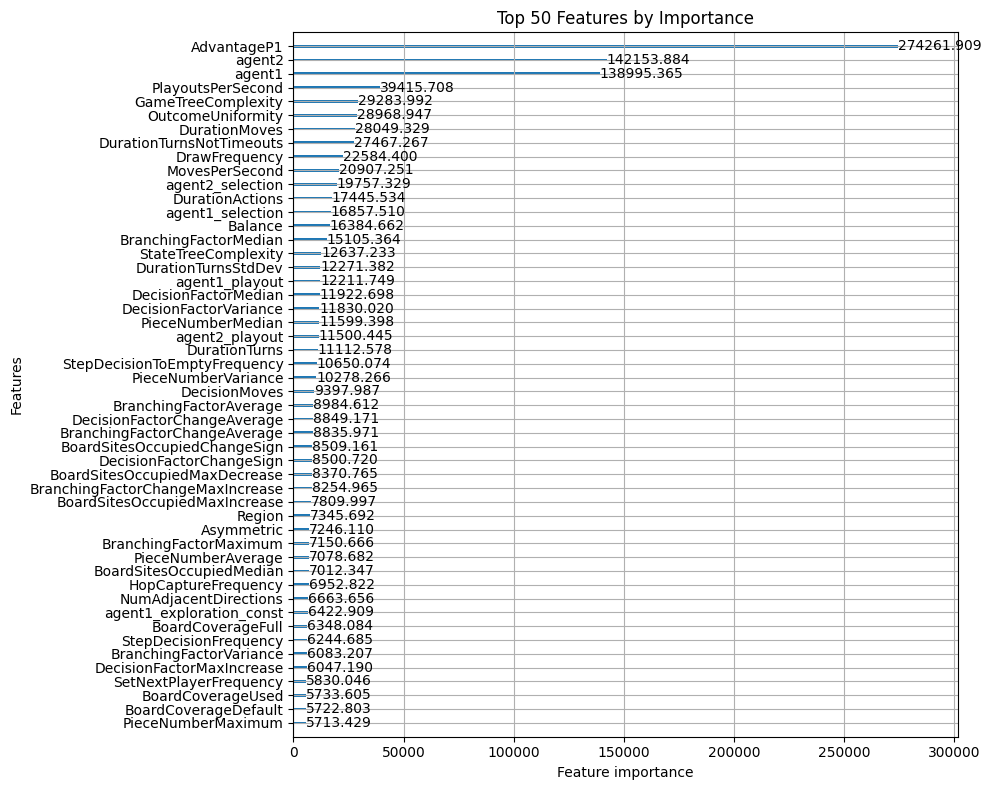

Fold 2 - RMSE: 0.4042609060478708
Fold 3


[100]	valid_0's rmse: 0.527748


[200]	valid_0's rmse: 0.500826


[300]	valid_0's rmse: 0.48738


[400]	valid_0's rmse: 0.477722


[500]	valid_0's rmse: 0.472472


[600]	valid_0's rmse: 0.467114


[700]	valid_0's rmse: 0.463531


[800]	valid_0's rmse: 0.46067


[900]	valid_0's rmse: 0.458585


[1000]	valid_0's rmse: 0.456511


[1100]	valid_0's rmse: 0.454971


[1200]	valid_0's rmse: 0.453708


[1300]	valid_0's rmse: 0.452397


[1400]	valid_0's rmse: 0.451238


[1500]	valid_0's rmse: 0.450278


[1600]	valid_0's rmse: 0.449321


[1700]	valid_0's rmse: 0.448372


[1800]	valid_0's rmse: 0.447682


[1900]	valid_0's rmse: 0.446838


[2000]	valid_0's rmse: 0.446221


[2100]	valid_0's rmse: 0.445694


[2200]	valid_0's rmse: 0.445174


[2300]	valid_0's rmse: 0.444667


[2400]	valid_0's rmse: 0.444213


[2500]	valid_0's rmse: 0.443789


[2600]	valid_0's rmse: 0.443419


[2700]	valid_0's rmse: 0.442952


[2800]	valid_0's rmse: 0.442598


[2900]	valid_0's rmse: 0.442324


[3000]	valid_0's rmse: 0.441986


[3100]	valid_0's rmse: 0.441675


[3200]	valid_0's rmse: 0.441388


[3300]	valid_0's rmse: 0.44106


[3400]	valid_0's rmse: 0.440808


[3500]	valid_0's rmse: 0.440577


[3600]	valid_0's rmse: 0.44041


[3700]	valid_0's rmse: 0.440246


[3800]	valid_0's rmse: 0.439984


[3900]	valid_0's rmse: 0.439796


[4000]	valid_0's rmse: 0.439544


[4100]	valid_0's rmse: 0.439356


[4200]	valid_0's rmse: 0.439206


[4300]	valid_0's rmse: 0.439151


[4400]	valid_0's rmse: 0.438997


[4500]	valid_0's rmse: 0.438748


[4600]	valid_0's rmse: 0.438624


[4700]	valid_0's rmse: 0.438464


[4800]	valid_0's rmse: 0.438358


[4900]	valid_0's rmse: 0.438209


[5000]	valid_0's rmse: 0.438009


[5100]	valid_0's rmse: 0.437872


[5200]	valid_0's rmse: 0.437792


[5300]	valid_0's rmse: 0.437575


[5400]	valid_0's rmse: 0.437552


[5500]	valid_0's rmse: 0.437423


[5600]	valid_0's rmse: 0.43735


[5700]	valid_0's rmse: 0.437354


[5800]	valid_0's rmse: 0.437301


[5900]	valid_0's rmse: 0.437225


[6000]	valid_0's rmse: 0.437145


[6100]	valid_0's rmse: 0.436978


[6200]	valid_0's rmse: 0.436916


[6300]	valid_0's rmse: 0.436843


[6400]	valid_0's rmse: 0.436793


[6500]	valid_0's rmse: 0.436764


[6600]	valid_0's rmse: 0.436689


[6700]	valid_0's rmse: 0.436624


[6800]	valid_0's rmse: 0.4366


[6900]	valid_0's rmse: 0.436581


[7000]	valid_0's rmse: 0.436544


[7100]	valid_0's rmse: 0.436421


[7200]	valid_0's rmse: 0.436337


[7300]	valid_0's rmse: 0.436258


[7400]	valid_0's rmse: 0.436256


[7500]	valid_0's rmse: 0.436246


[7600]	valid_0's rmse: 0.436182


[7700]	valid_0's rmse: 0.436111


[7800]	valid_0's rmse: 0.436017


[7900]	valid_0's rmse: 0.435946


[8000]	valid_0's rmse: 0.435881


[8100]	valid_0's rmse: 0.43587


[8200]	valid_0's rmse: 0.435779


[8300]	valid_0's rmse: 0.435704


[8400]	valid_0's rmse: 0.435719


[8500]	valid_0's rmse: 0.4357


[8600]	valid_0's rmse: 0.435689


[8700]	valid_0's rmse: 0.43558


[8800]	valid_0's rmse: 0.435525


[8900]	valid_0's rmse: 0.435572


[9000]	valid_0's rmse: 0.435547


[9100]	valid_0's rmse: 0.435539


[9200]	valid_0's rmse: 0.435508


[9300]	valid_0's rmse: 0.435482


[9400]	valid_0's rmse: 0.435457


[9500]	valid_0's rmse: 0.435409


[9600]	valid_0's rmse: 0.435374


[9700]	valid_0's rmse: 0.435388


[9800]	valid_0's rmse: 0.435355


[9900]	valid_0's rmse: 0.435364


[10000]	valid_0's rmse: 0.435353


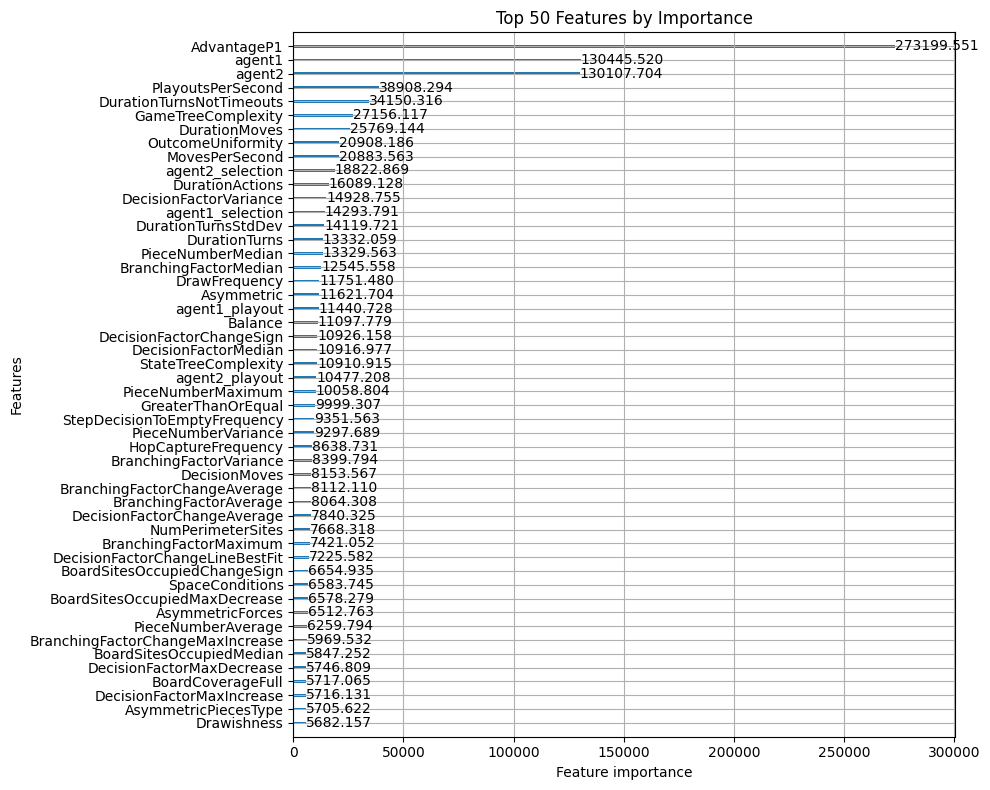

Fold 3 - RMSE: 0.4345682501718881
Fold 4


[100]	valid_0's rmse: 0.521507


[200]	valid_0's rmse: 0.495925


[300]	valid_0's rmse: 0.485038


[400]	valid_0's rmse: 0.477644


[500]	valid_0's rmse: 0.472245


[600]	valid_0's rmse: 0.467742


[700]	valid_0's rmse: 0.465036


[800]	valid_0's rmse: 0.462349


[900]	valid_0's rmse: 0.460502


[1000]	valid_0's rmse: 0.458692


[1100]	valid_0's rmse: 0.457103


[1200]	valid_0's rmse: 0.455985


[1300]	valid_0's rmse: 0.454648


[1400]	valid_0's rmse: 0.453777


[1500]	valid_0's rmse: 0.452973


[1600]	valid_0's rmse: 0.452148


[1700]	valid_0's rmse: 0.451525


[1800]	valid_0's rmse: 0.45084


[1900]	valid_0's rmse: 0.45023


[2000]	valid_0's rmse: 0.449763


[2100]	valid_0's rmse: 0.449171


[2200]	valid_0's rmse: 0.448699


[2300]	valid_0's rmse: 0.448246


[2400]	valid_0's rmse: 0.447887


[2500]	valid_0's rmse: 0.447594


[2600]	valid_0's rmse: 0.447316


[2700]	valid_0's rmse: 0.446993


[2800]	valid_0's rmse: 0.446732


[2900]	valid_0's rmse: 0.446558


[3000]	valid_0's rmse: 0.446422


[3100]	valid_0's rmse: 0.446198


[3200]	valid_0's rmse: 0.445981


[3300]	valid_0's rmse: 0.445638


[3400]	valid_0's rmse: 0.445383


[3500]	valid_0's rmse: 0.445054


[3600]	valid_0's rmse: 0.44489


[3700]	valid_0's rmse: 0.444785


[3800]	valid_0's rmse: 0.444568


[3900]	valid_0's rmse: 0.444332


[4000]	valid_0's rmse: 0.444195


[4100]	valid_0's rmse: 0.44398


[4200]	valid_0's rmse: 0.443906


[4300]	valid_0's rmse: 0.443797


[4400]	valid_0's rmse: 0.443625


[4500]	valid_0's rmse: 0.443632


[4600]	valid_0's rmse: 0.443558


[4700]	valid_0's rmse: 0.443424


[4800]	valid_0's rmse: 0.443283


[4900]	valid_0's rmse: 0.443176


[5000]	valid_0's rmse: 0.443069


[5100]	valid_0's rmse: 0.442909


[5200]	valid_0's rmse: 0.44288


[5300]	valid_0's rmse: 0.44277


[5400]	valid_0's rmse: 0.442736


[5500]	valid_0's rmse: 0.442708


[5600]	valid_0's rmse: 0.442609


[5700]	valid_0's rmse: 0.44249


[5800]	valid_0's rmse: 0.442319


[5900]	valid_0's rmse: 0.44227


[6000]	valid_0's rmse: 0.442193


[6100]	valid_0's rmse: 0.442103


[6200]	valid_0's rmse: 0.442087


[6300]	valid_0's rmse: 0.442038


[6400]	valid_0's rmse: 0.441982


[6500]	valid_0's rmse: 0.441957


[6600]	valid_0's rmse: 0.441915


[6700]	valid_0's rmse: 0.441926


[6800]	valid_0's rmse: 0.441868


[6900]	valid_0's rmse: 0.441788


[7000]	valid_0's rmse: 0.441717


[7100]	valid_0's rmse: 0.441678


[7200]	valid_0's rmse: 0.441695


[7300]	valid_0's rmse: 0.441574


[7400]	valid_0's rmse: 0.441444


[7500]	valid_0's rmse: 0.441371


[7600]	valid_0's rmse: 0.441361


[7700]	valid_0's rmse: 0.441251


[7800]	valid_0's rmse: 0.441203


[7900]	valid_0's rmse: 0.441208


[8000]	valid_0's rmse: 0.441204


[8100]	valid_0's rmse: 0.441217


[8200]	valid_0's rmse: 0.441119


[8300]	valid_0's rmse: 0.441055


[8400]	valid_0's rmse: 0.441074


[8500]	valid_0's rmse: 0.441105


[8600]	valid_0's rmse: 0.441116


[8700]	valid_0's rmse: 0.441102


[8800]	valid_0's rmse: 0.441061


[8900]	valid_0's rmse: 0.440969


[9000]	valid_0's rmse: 0.440927


[9100]	valid_0's rmse: 0.440938


[9200]	valid_0's rmse: 0.440941


[9300]	valid_0's rmse: 0.440973


[9400]	valid_0's rmse: 0.440895


[9500]	valid_0's rmse: 0.440948


[9600]	valid_0's rmse: 0.440944


[9700]	valid_0's rmse: 0.440935


[9800]	valid_0's rmse: 0.440887


[9900]	valid_0's rmse: 0.440903


[10000]	valid_0's rmse: 0.440877


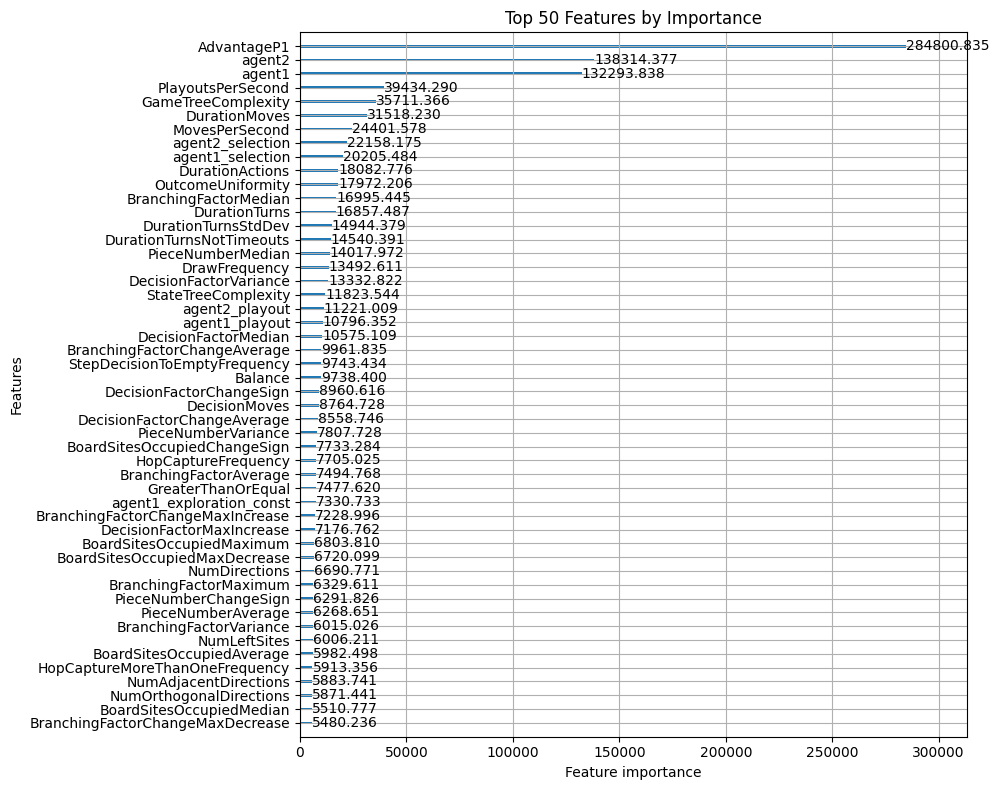

Fold 4 - RMSE: 0.44042309203353414
Fold 5


[100]	valid_0's rmse: 0.518317


[200]	valid_0's rmse: 0.494533


[300]	valid_0's rmse: 0.482531


[400]	valid_0's rmse: 0.474402


[500]	valid_0's rmse: 0.468657


[600]	valid_0's rmse: 0.465006


[700]	valid_0's rmse: 0.461998


[800]	valid_0's rmse: 0.458861


[900]	valid_0's rmse: 0.456653


[1000]	valid_0's rmse: 0.454704


[1100]	valid_0's rmse: 0.452772


[1200]	valid_0's rmse: 0.450971


[1300]	valid_0's rmse: 0.449696


[1400]	valid_0's rmse: 0.448455


[1500]	valid_0's rmse: 0.447446


[1600]	valid_0's rmse: 0.446569


[1700]	valid_0's rmse: 0.445783


[1800]	valid_0's rmse: 0.444858


[1900]	valid_0's rmse: 0.444212


[2000]	valid_0's rmse: 0.443504


[2100]	valid_0's rmse: 0.44296


[2200]	valid_0's rmse: 0.44243


[2300]	valid_0's rmse: 0.441893


[2400]	valid_0's rmse: 0.441461


[2500]	valid_0's rmse: 0.441052


[2600]	valid_0's rmse: 0.440658


[2700]	valid_0's rmse: 0.440291


[2800]	valid_0's rmse: 0.439997


[2900]	valid_0's rmse: 0.439599


[3000]	valid_0's rmse: 0.439282


[3100]	valid_0's rmse: 0.439069


[3200]	valid_0's rmse: 0.438787


[3300]	valid_0's rmse: 0.438517


[3400]	valid_0's rmse: 0.438181


[3500]	valid_0's rmse: 0.437882


[3600]	valid_0's rmse: 0.437719


[3700]	valid_0's rmse: 0.437516


[3800]	valid_0's rmse: 0.437268


[3900]	valid_0's rmse: 0.437066


[4000]	valid_0's rmse: 0.436836


[4100]	valid_0's rmse: 0.436593


[4200]	valid_0's rmse: 0.436386


[4300]	valid_0's rmse: 0.436295


[4400]	valid_0's rmse: 0.436236


[4500]	valid_0's rmse: 0.436083


[4600]	valid_0's rmse: 0.43593


[4700]	valid_0's rmse: 0.435795


[4800]	valid_0's rmse: 0.435688


[4900]	valid_0's rmse: 0.435649


[5000]	valid_0's rmse: 0.435435


[5100]	valid_0's rmse: 0.435317


[5200]	valid_0's rmse: 0.435148


[5300]	valid_0's rmse: 0.434979


[5400]	valid_0's rmse: 0.434898


[5500]	valid_0's rmse: 0.434749


[5600]	valid_0's rmse: 0.434678


[5700]	valid_0's rmse: 0.434561


[5800]	valid_0's rmse: 0.434359


[5900]	valid_0's rmse: 0.434219


[6000]	valid_0's rmse: 0.434191


[6100]	valid_0's rmse: 0.434079


[6200]	valid_0's rmse: 0.434031


[6300]	valid_0's rmse: 0.433877


[6400]	valid_0's rmse: 0.433784


[6500]	valid_0's rmse: 0.433786


[6600]	valid_0's rmse: 0.433698


[6700]	valid_0's rmse: 0.433663


[6800]	valid_0's rmse: 0.433583


[6900]	valid_0's rmse: 0.433489


[7000]	valid_0's rmse: 0.433444


[7100]	valid_0's rmse: 0.433389


[7200]	valid_0's rmse: 0.433312


[7300]	valid_0's rmse: 0.433246


[7400]	valid_0's rmse: 0.433209


[7500]	valid_0's rmse: 0.433204


[7600]	valid_0's rmse: 0.433193


[7700]	valid_0's rmse: 0.433171


[7800]	valid_0's rmse: 0.433147


[7900]	valid_0's rmse: 0.433099


[8000]	valid_0's rmse: 0.433078


[8100]	valid_0's rmse: 0.432992


[8200]	valid_0's rmse: 0.432931


[8300]	valid_0's rmse: 0.4329


[8400]	valid_0's rmse: 0.432822


[8500]	valid_0's rmse: 0.432776


[8600]	valid_0's rmse: 0.432747


[8700]	valid_0's rmse: 0.432701


[8800]	valid_0's rmse: 0.432653


[8900]	valid_0's rmse: 0.43267


[9000]	valid_0's rmse: 0.432665


[9100]	valid_0's rmse: 0.432696


[9200]	valid_0's rmse: 0.432706


[9300]	valid_0's rmse: 0.432667


[9400]	valid_0's rmse: 0.432645


[9500]	valid_0's rmse: 0.432589


[9600]	valid_0's rmse: 0.432584


[9700]	valid_0's rmse: 0.432551


[9800]	valid_0's rmse: 0.43253


[9900]	valid_0's rmse: 0.432498


[10000]	valid_0's rmse: 0.432476


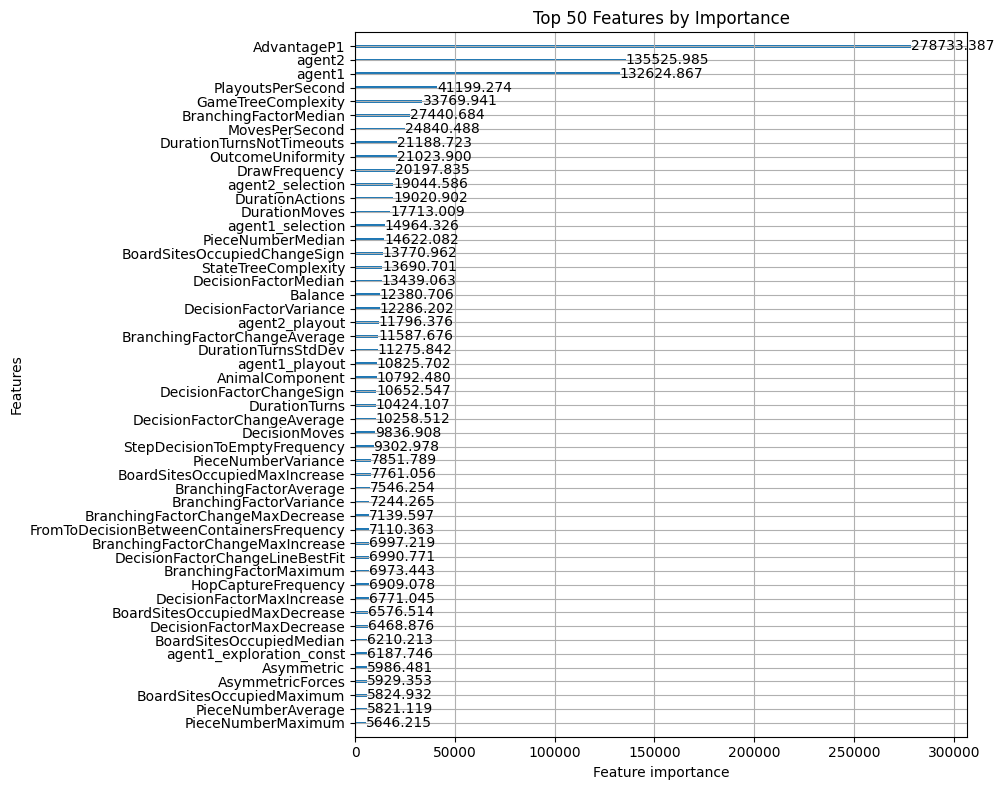

Fold 5 - RMSE: 0.4318488333859735
List of oof scores: [0.4134303290569066, 0.4042609060478708, 0.4345682501718881, 0.44042309203353414, 0.4318488333859735]
Average oof score: 0.42490628213923465


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.506614


[200]	valid_0's rmse: 0.482102


[300]	valid_0's rmse: 0.468474


[400]	valid_0's rmse: 0.46172


[500]	valid_0's rmse: 0.457438


[600]	valid_0's rmse: 0.453937


[700]	valid_0's rmse: 0.4509


[800]	valid_0's rmse: 0.448589


[900]	valid_0's rmse: 0.446618


[1000]	valid_0's rmse: 0.445109


[1100]	valid_0's rmse: 0.443707


[1200]	valid_0's rmse: 0.442687


[1300]	valid_0's rmse: 0.44165


[1400]	valid_0's rmse: 0.440615


[1500]	valid_0's rmse: 0.440024


[1600]	valid_0's rmse: 0.439264


[1700]	valid_0's rmse: 0.438686


[1800]	valid_0's rmse: 0.438126


[1900]	valid_0's rmse: 0.437636


[2000]	valid_0's rmse: 0.437125


[2100]	valid_0's rmse: 0.436666


[2200]	valid_0's rmse: 0.436147


[2300]	valid_0's rmse: 0.435795


[2400]	valid_0's rmse: 0.435422


[2500]	valid_0's rmse: 0.435125


[2600]	valid_0's rmse: 0.434906


[2700]	valid_0's rmse: 0.434648


[2800]	valid_0's rmse: 0.434506


[2900]	valid_0's rmse: 0.434199


[3000]	valid_0's rmse: 0.433903


[3100]	valid_0's rmse: 0.43371


[3200]	valid_0's rmse: 0.433598


[3300]	valid_0's rmse: 0.433343


[3400]	valid_0's rmse: 0.433099


[3500]	valid_0's rmse: 0.432825


[3600]	valid_0's rmse: 0.432743


[3700]	valid_0's rmse: 0.43262


[3800]	valid_0's rmse: 0.432409


[3900]	valid_0's rmse: 0.432291


[4000]	valid_0's rmse: 0.432174


[4100]	valid_0's rmse: 0.43217


[4200]	valid_0's rmse: 0.432093


[4300]	valid_0's rmse: 0.431934


[4400]	valid_0's rmse: 0.431749


[4500]	valid_0's rmse: 0.431671


[4600]	valid_0's rmse: 0.431525


[4700]	valid_0's rmse: 0.431417


[4800]	valid_0's rmse: 0.431312


[4900]	valid_0's rmse: 0.431186


[5000]	valid_0's rmse: 0.431068


[5100]	valid_0's rmse: 0.431048


[5200]	valid_0's rmse: 0.430967


[5300]	valid_0's rmse: 0.430866


[5400]	valid_0's rmse: 0.430798


[5500]	valid_0's rmse: 0.43075


[5600]	valid_0's rmse: 0.430613


[5700]	valid_0's rmse: 0.430605


[5800]	valid_0's rmse: 0.430467


[5900]	valid_0's rmse: 0.430402


[6000]	valid_0's rmse: 0.430357


[6100]	valid_0's rmse: 0.4303


[6200]	valid_0's rmse: 0.430247


[6300]	valid_0's rmse: 0.430216


[6400]	valid_0's rmse: 0.430103


[6500]	valid_0's rmse: 0.430026


[6600]	valid_0's rmse: 0.429952


[6700]	valid_0's rmse: 0.429842


[6800]	valid_0's rmse: 0.429767


[6900]	valid_0's rmse: 0.429746


[7000]	valid_0's rmse: 0.429683


[7100]	valid_0's rmse: 0.429587


[7200]	valid_0's rmse: 0.429538


[7300]	valid_0's rmse: 0.429502


[7400]	valid_0's rmse: 0.429421


[7500]	valid_0's rmse: 0.429426


[7600]	valid_0's rmse: 0.429387


[7700]	valid_0's rmse: 0.429348


[7800]	valid_0's rmse: 0.429272


[7900]	valid_0's rmse: 0.429281


[8000]	valid_0's rmse: 0.429205


[8100]	valid_0's rmse: 0.429156


[8200]	valid_0's rmse: 0.42907


[8300]	valid_0's rmse: 0.429066


[8400]	valid_0's rmse: 0.42905


[8500]	valid_0's rmse: 0.428988


[8600]	valid_0's rmse: 0.429004


[8700]	valid_0's rmse: 0.428939


[8800]	valid_0's rmse: 0.42892


[8900]	valid_0's rmse: 0.428945


[9000]	valid_0's rmse: 0.428939


[9100]	valid_0's rmse: 0.428948


[9200]	valid_0's rmse: 0.429004


[9300]	valid_0's rmse: 0.429008


[9400]	valid_0's rmse: 0.42892


[9500]	valid_0's rmse: 0.428897


[9600]	valid_0's rmse: 0.42887


[9700]	valid_0's rmse: 0.428846


[9800]	valid_0's rmse: 0.428811


[9900]	valid_0's rmse: 0.428798


[10000]	valid_0's rmse: 0.428819


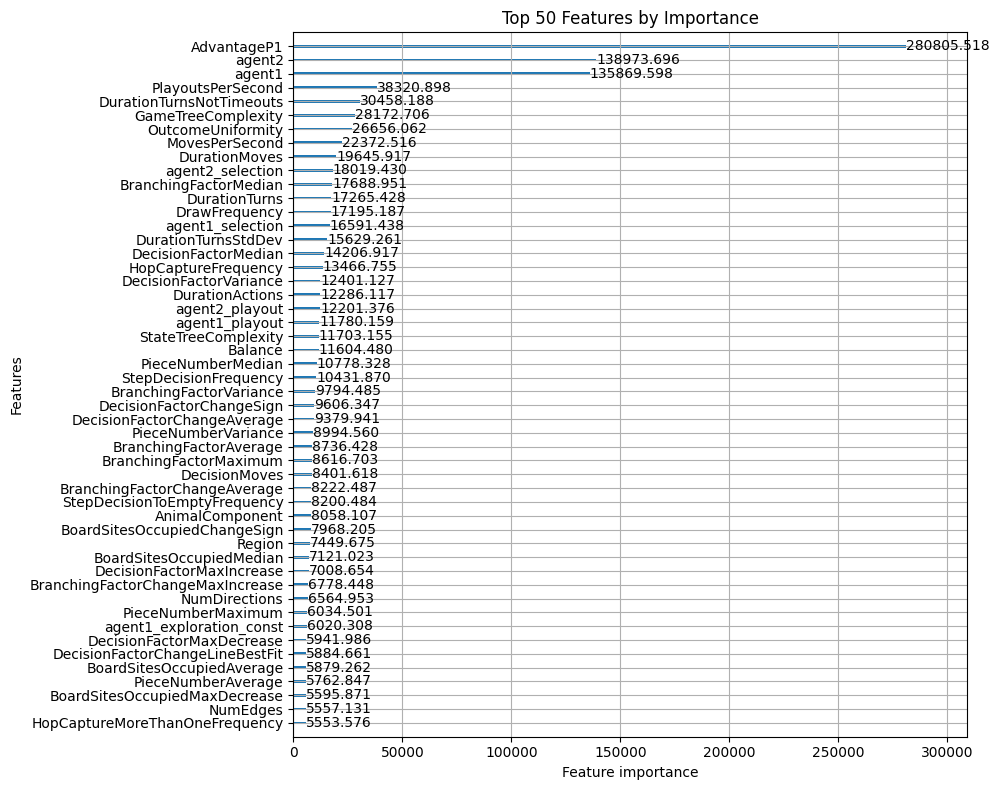

Fold 1 - RMSE: 0.4282455830745386
Fold 2


[100]	valid_0's rmse: 0.505877


[200]	valid_0's rmse: 0.48251


[300]	valid_0's rmse: 0.469078


[400]	valid_0's rmse: 0.460048


[500]	valid_0's rmse: 0.453112


[600]	valid_0's rmse: 0.447809


[700]	valid_0's rmse: 0.444355


[800]	valid_0's rmse: 0.441259


[900]	valid_0's rmse: 0.438752


[1000]	valid_0's rmse: 0.436637


[1100]	valid_0's rmse: 0.434861


[1200]	valid_0's rmse: 0.433188


[1300]	valid_0's rmse: 0.431659


[1400]	valid_0's rmse: 0.430325


[1500]	valid_0's rmse: 0.429261


[1600]	valid_0's rmse: 0.428367


[1700]	valid_0's rmse: 0.427629


[1800]	valid_0's rmse: 0.426984


[1900]	valid_0's rmse: 0.426179


[2000]	valid_0's rmse: 0.425584


[2100]	valid_0's rmse: 0.424916


[2200]	valid_0's rmse: 0.424377


[2300]	valid_0's rmse: 0.423901


[2400]	valid_0's rmse: 0.423428


[2500]	valid_0's rmse: 0.422936


[2600]	valid_0's rmse: 0.422449


[2700]	valid_0's rmse: 0.422032


[2800]	valid_0's rmse: 0.421562


[2900]	valid_0's rmse: 0.421332


[3000]	valid_0's rmse: 0.421028


[3100]	valid_0's rmse: 0.420669


[3200]	valid_0's rmse: 0.420307


[3300]	valid_0's rmse: 0.42007


[3400]	valid_0's rmse: 0.419858


[3500]	valid_0's rmse: 0.419633


[3600]	valid_0's rmse: 0.419386


[3700]	valid_0's rmse: 0.419175


[3800]	valid_0's rmse: 0.419044


[3900]	valid_0's rmse: 0.418864


[4000]	valid_0's rmse: 0.418722


[4100]	valid_0's rmse: 0.418473


[4200]	valid_0's rmse: 0.418328


[4300]	valid_0's rmse: 0.418216


[4400]	valid_0's rmse: 0.418055


[4500]	valid_0's rmse: 0.417897


[4600]	valid_0's rmse: 0.417733


[4700]	valid_0's rmse: 0.417643


[4800]	valid_0's rmse: 0.417592


[4900]	valid_0's rmse: 0.41742


[5000]	valid_0's rmse: 0.417292


[5100]	valid_0's rmse: 0.41722


[5200]	valid_0's rmse: 0.417135


[5300]	valid_0's rmse: 0.417062


[5400]	valid_0's rmse: 0.41694


[5500]	valid_0's rmse: 0.41689


[5600]	valid_0's rmse: 0.416834


[5700]	valid_0's rmse: 0.416733


[5800]	valid_0's rmse: 0.416649


[5900]	valid_0's rmse: 0.416555


[6000]	valid_0's rmse: 0.416481


[6100]	valid_0's rmse: 0.416349


[6200]	valid_0's rmse: 0.416325


[6300]	valid_0's rmse: 0.416255


[6400]	valid_0's rmse: 0.416169


[6500]	valid_0's rmse: 0.416078


[6600]	valid_0's rmse: 0.416001


[6700]	valid_0's rmse: 0.415878


[6800]	valid_0's rmse: 0.415862


[6900]	valid_0's rmse: 0.415758


[7000]	valid_0's rmse: 0.41569


[7100]	valid_0's rmse: 0.415612


[7200]	valid_0's rmse: 0.415581


[7300]	valid_0's rmse: 0.415486


[7400]	valid_0's rmse: 0.415479


[7500]	valid_0's rmse: 0.415479


[7600]	valid_0's rmse: 0.415448


[7700]	valid_0's rmse: 0.415404


[7800]	valid_0's rmse: 0.415349


[7900]	valid_0's rmse: 0.415308


[8000]	valid_0's rmse: 0.415307


[8100]	valid_0's rmse: 0.415282


[8200]	valid_0's rmse: 0.415195


[8300]	valid_0's rmse: 0.415145


[8400]	valid_0's rmse: 0.415123


[8500]	valid_0's rmse: 0.415093


[8600]	valid_0's rmse: 0.415086


[8700]	valid_0's rmse: 0.415071


[8800]	valid_0's rmse: 0.415089


[8900]	valid_0's rmse: 0.414988


[9000]	valid_0's rmse: 0.414954


[9100]	valid_0's rmse: 0.414916


[9200]	valid_0's rmse: 0.414857


[9300]	valid_0's rmse: 0.414791


[9400]	valid_0's rmse: 0.414707


[9500]	valid_0's rmse: 0.414678


[9600]	valid_0's rmse: 0.414601


[9700]	valid_0's rmse: 0.414608


[9800]	valid_0's rmse: 0.414552


[9900]	valid_0's rmse: 0.414509


[10000]	valid_0's rmse: 0.414537


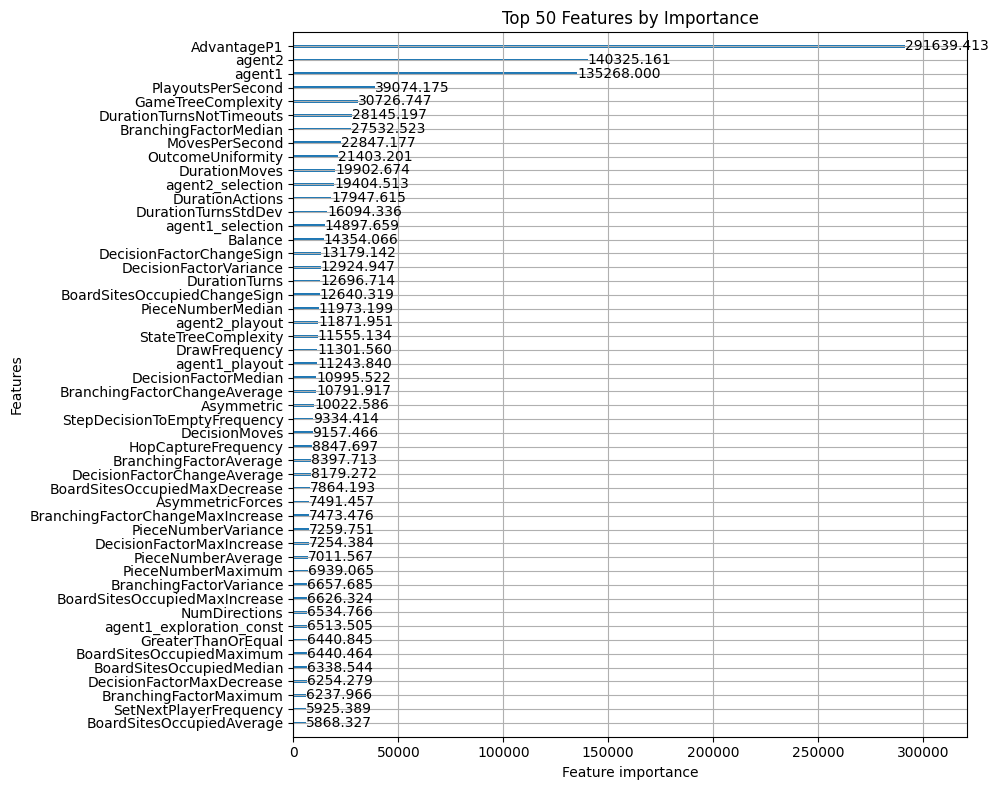

Fold 2 - RMSE: 0.4141171950487219
Fold 3


[100]	valid_0's rmse: 0.499072


[200]	valid_0's rmse: 0.473854


[300]	valid_0's rmse: 0.463641


[400]	valid_0's rmse: 0.456665


[500]	valid_0's rmse: 0.450847


[600]	valid_0's rmse: 0.447572


[700]	valid_0's rmse: 0.445094


[800]	valid_0's rmse: 0.442566


[900]	valid_0's rmse: 0.440908


[1000]	valid_0's rmse: 0.43934


[1100]	valid_0's rmse: 0.437989


[1200]	valid_0's rmse: 0.436839


[1300]	valid_0's rmse: 0.436075


[1400]	valid_0's rmse: 0.435194


[1500]	valid_0's rmse: 0.434173


[1600]	valid_0's rmse: 0.433447


[1700]	valid_0's rmse: 0.432925


[1800]	valid_0's rmse: 0.432373


[1900]	valid_0's rmse: 0.432047


[2000]	valid_0's rmse: 0.431694


[2100]	valid_0's rmse: 0.431294


[2200]	valid_0's rmse: 0.431064


[2300]	valid_0's rmse: 0.430632


[2400]	valid_0's rmse: 0.430388


[2500]	valid_0's rmse: 0.429983


[2600]	valid_0's rmse: 0.429568


[2700]	valid_0's rmse: 0.429198


[2800]	valid_0's rmse: 0.428953


[2900]	valid_0's rmse: 0.428667


[3000]	valid_0's rmse: 0.428426


[3100]	valid_0's rmse: 0.428185


[3200]	valid_0's rmse: 0.42795


[3300]	valid_0's rmse: 0.427748


[3400]	valid_0's rmse: 0.427566


[3500]	valid_0's rmse: 0.427358


[3600]	valid_0's rmse: 0.427229


[3700]	valid_0's rmse: 0.42716


[3800]	valid_0's rmse: 0.427099


[3900]	valid_0's rmse: 0.426952


[4000]	valid_0's rmse: 0.426834


[4100]	valid_0's rmse: 0.42665


[4200]	valid_0's rmse: 0.426586


[4300]	valid_0's rmse: 0.426492


[4400]	valid_0's rmse: 0.426357


[4500]	valid_0's rmse: 0.426314


[4600]	valid_0's rmse: 0.42619


[4700]	valid_0's rmse: 0.426084


[4800]	valid_0's rmse: 0.425929


[4900]	valid_0's rmse: 0.425906


[5000]	valid_0's rmse: 0.42571


[5100]	valid_0's rmse: 0.425639


[5200]	valid_0's rmse: 0.425588


[5300]	valid_0's rmse: 0.425592


[5400]	valid_0's rmse: 0.42545


[5500]	valid_0's rmse: 0.425367


[5600]	valid_0's rmse: 0.425329


[5700]	valid_0's rmse: 0.425237


[5800]	valid_0's rmse: 0.425159


[5900]	valid_0's rmse: 0.425172


[6000]	valid_0's rmse: 0.425153


[6100]	valid_0's rmse: 0.425131


[6200]	valid_0's rmse: 0.425021


[6300]	valid_0's rmse: 0.425029


[6400]	valid_0's rmse: 0.425007


[6500]	valid_0's rmse: 0.425028


[6600]	valid_0's rmse: 0.424964


[6700]	valid_0's rmse: 0.42489


[6800]	valid_0's rmse: 0.424837


[6900]	valid_0's rmse: 0.424821


[7000]	valid_0's rmse: 0.424743


[7100]	valid_0's rmse: 0.424708


[7200]	valid_0's rmse: 0.424623


[7300]	valid_0's rmse: 0.424605


[7400]	valid_0's rmse: 0.424552


[7500]	valid_0's rmse: 0.424513


[7600]	valid_0's rmse: 0.424495


[7700]	valid_0's rmse: 0.424451


[7800]	valid_0's rmse: 0.42443


[7900]	valid_0's rmse: 0.424392


[8000]	valid_0's rmse: 0.424397


[8100]	valid_0's rmse: 0.424472


[8200]	valid_0's rmse: 0.424472


[8300]	valid_0's rmse: 0.424464


[8400]	valid_0's rmse: 0.424471


[8500]	valid_0's rmse: 0.424431


[8600]	valid_0's rmse: 0.424406


[8700]	valid_0's rmse: 0.424362


[8800]	valid_0's rmse: 0.424338


[8900]	valid_0's rmse: 0.424261


[9000]	valid_0's rmse: 0.424228


[9100]	valid_0's rmse: 0.424199


[9200]	valid_0's rmse: 0.424182


[9300]	valid_0's rmse: 0.424172


[9400]	valid_0's rmse: 0.42414


[9500]	valid_0's rmse: 0.424065


[9600]	valid_0's rmse: 0.424014


[9700]	valid_0's rmse: 0.423984


[9800]	valid_0's rmse: 0.423964


[9900]	valid_0's rmse: 0.423942


[10000]	valid_0's rmse: 0.423929


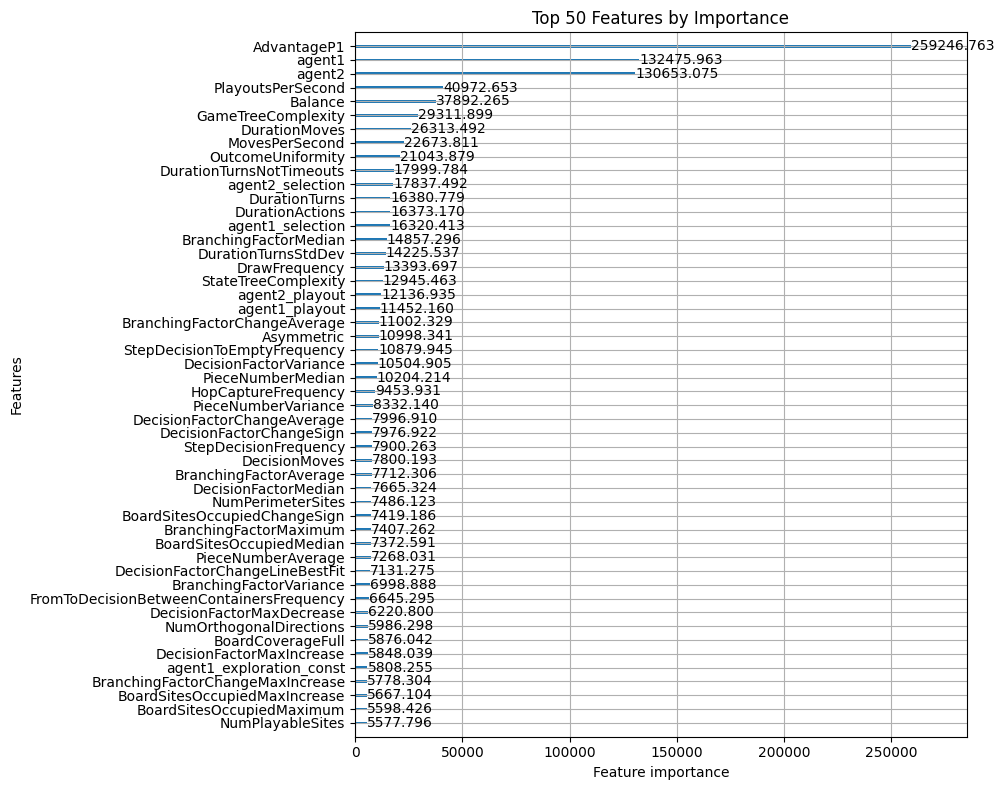

Fold 3 - RMSE: 0.42348385857974263
Fold 4


[100]	valid_0's rmse: 0.489735


[200]	valid_0's rmse: 0.465754


[300]	valid_0's rmse: 0.455839


[400]	valid_0's rmse: 0.448853


[500]	valid_0's rmse: 0.443872


[600]	valid_0's rmse: 0.440384


[700]	valid_0's rmse: 0.437632


[800]	valid_0's rmse: 0.43551


[900]	valid_0's rmse: 0.433724


[1000]	valid_0's rmse: 0.431938


[1100]	valid_0's rmse: 0.430295


[1200]	valid_0's rmse: 0.429244


[1300]	valid_0's rmse: 0.428191


[1400]	valid_0's rmse: 0.427361


[1500]	valid_0's rmse: 0.426546


[1600]	valid_0's rmse: 0.426021


[1700]	valid_0's rmse: 0.425445


[1800]	valid_0's rmse: 0.424992


[1900]	valid_0's rmse: 0.424439


[2000]	valid_0's rmse: 0.42397


[2100]	valid_0's rmse: 0.423502


[2200]	valid_0's rmse: 0.423094


[2300]	valid_0's rmse: 0.422707


[2400]	valid_0's rmse: 0.422339


[2500]	valid_0's rmse: 0.422068


[2600]	valid_0's rmse: 0.421794


[2700]	valid_0's rmse: 0.421596


[2800]	valid_0's rmse: 0.421398


[2900]	valid_0's rmse: 0.421185


[3000]	valid_0's rmse: 0.420975


[3100]	valid_0's rmse: 0.420702


[3200]	valid_0's rmse: 0.420567


[3300]	valid_0's rmse: 0.420393


[3400]	valid_0's rmse: 0.420176


[3500]	valid_0's rmse: 0.420047


[3600]	valid_0's rmse: 0.419899


[3700]	valid_0's rmse: 0.419752


[3800]	valid_0's rmse: 0.419614


[3900]	valid_0's rmse: 0.419382


[4000]	valid_0's rmse: 0.419251


[4100]	valid_0's rmse: 0.419052


[4200]	valid_0's rmse: 0.419004


[4300]	valid_0's rmse: 0.418908


[4400]	valid_0's rmse: 0.418801


[4500]	valid_0's rmse: 0.4187


[4600]	valid_0's rmse: 0.418673


[4700]	valid_0's rmse: 0.418633


[4800]	valid_0's rmse: 0.418542


[4900]	valid_0's rmse: 0.418348


[5000]	valid_0's rmse: 0.418312


[5100]	valid_0's rmse: 0.41818


[5200]	valid_0's rmse: 0.418068


[5300]	valid_0's rmse: 0.417888


[5400]	valid_0's rmse: 0.41784


[5500]	valid_0's rmse: 0.417788


[5600]	valid_0's rmse: 0.417701


[5700]	valid_0's rmse: 0.4176


[5800]	valid_0's rmse: 0.417494


[5900]	valid_0's rmse: 0.417481


[6000]	valid_0's rmse: 0.417392


[6100]	valid_0's rmse: 0.417358


[6200]	valid_0's rmse: 0.417298


[6300]	valid_0's rmse: 0.417153


[6400]	valid_0's rmse: 0.417087


[6500]	valid_0's rmse: 0.417073


[6600]	valid_0's rmse: 0.417065


[6700]	valid_0's rmse: 0.417023


[6800]	valid_0's rmse: 0.416983


[6900]	valid_0's rmse: 0.416947


[7000]	valid_0's rmse: 0.416909


[7100]	valid_0's rmse: 0.416869


[7200]	valid_0's rmse: 0.416851


[7300]	valid_0's rmse: 0.4168


[7400]	valid_0's rmse: 0.416771


[7500]	valid_0's rmse: 0.416789


[7600]	valid_0's rmse: 0.41675


[7700]	valid_0's rmse: 0.416696


[7800]	valid_0's rmse: 0.416632


[7900]	valid_0's rmse: 0.416672


[8000]	valid_0's rmse: 0.416664


[8100]	valid_0's rmse: 0.416672


[8200]	valid_0's rmse: 0.416628


[8300]	valid_0's rmse: 0.416583


[8400]	valid_0's rmse: 0.416531


[8500]	valid_0's rmse: 0.416514


[8600]	valid_0's rmse: 0.416472


[8700]	valid_0's rmse: 0.416444


[8800]	valid_0's rmse: 0.416398


[8900]	valid_0's rmse: 0.416341


[9000]	valid_0's rmse: 0.416336


[9100]	valid_0's rmse: 0.416307


[9200]	valid_0's rmse: 0.416277


[9300]	valid_0's rmse: 0.416295


[9400]	valid_0's rmse: 0.416274


[9500]	valid_0's rmse: 0.416249


[9600]	valid_0's rmse: 0.41618


[9700]	valid_0's rmse: 0.416217


[9800]	valid_0's rmse: 0.416168


[9900]	valid_0's rmse: 0.416154


[10000]	valid_0's rmse: 0.416132


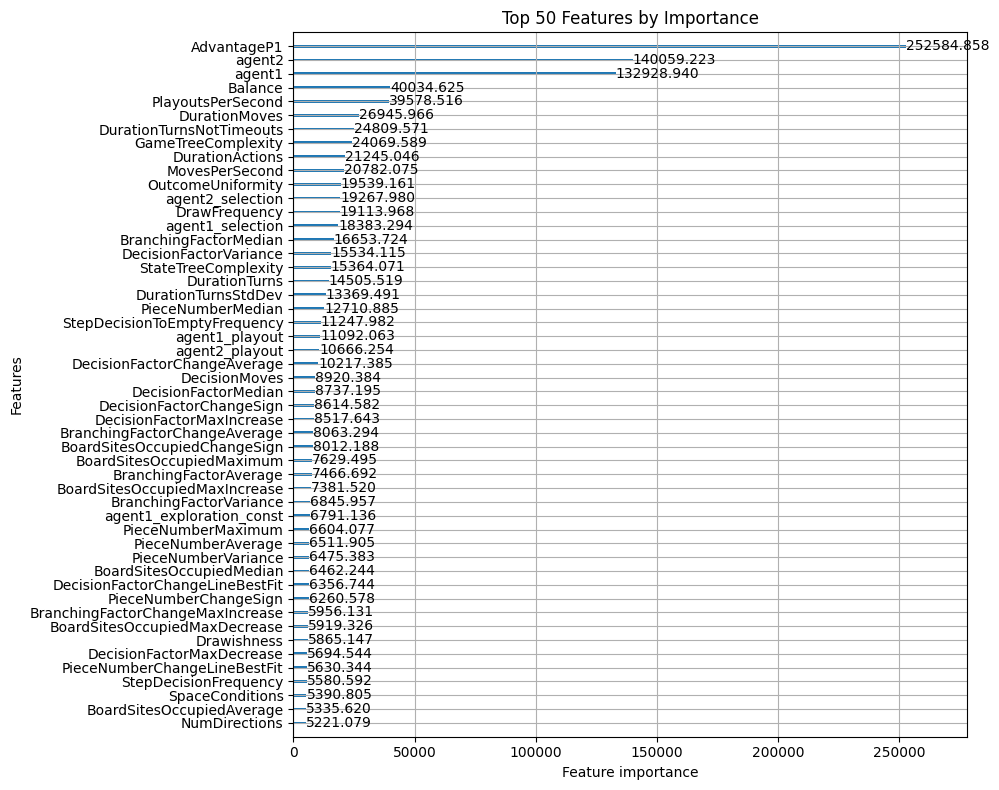

Fold 4 - RMSE: 0.41544959342333065
Fold 5


[100]	valid_0's rmse: 0.511118


[200]	valid_0's rmse: 0.492006


[300]	valid_0's rmse: 0.480798


[400]	valid_0's rmse: 0.474008


[500]	valid_0's rmse: 0.467692


[600]	valid_0's rmse: 0.462406


[700]	valid_0's rmse: 0.459026


[800]	valid_0's rmse: 0.456886


[900]	valid_0's rmse: 0.454463


[1000]	valid_0's rmse: 0.452181


[1100]	valid_0's rmse: 0.450415


[1200]	valid_0's rmse: 0.44907


[1300]	valid_0's rmse: 0.44786


[1400]	valid_0's rmse: 0.446681


[1500]	valid_0's rmse: 0.445761


[1600]	valid_0's rmse: 0.444868


[1700]	valid_0's rmse: 0.444056


[1800]	valid_0's rmse: 0.443224


[1900]	valid_0's rmse: 0.442461


[2000]	valid_0's rmse: 0.441841


[2100]	valid_0's rmse: 0.441253


[2200]	valid_0's rmse: 0.440759


[2300]	valid_0's rmse: 0.440144


[2400]	valid_0's rmse: 0.439433


[2500]	valid_0's rmse: 0.439084


[2600]	valid_0's rmse: 0.438637


[2700]	valid_0's rmse: 0.438268


[2800]	valid_0's rmse: 0.437898


[2900]	valid_0's rmse: 0.437572


[3000]	valid_0's rmse: 0.437271


[3100]	valid_0's rmse: 0.436984


[3200]	valid_0's rmse: 0.436635


[3300]	valid_0's rmse: 0.436432


[3400]	valid_0's rmse: 0.436144


[3500]	valid_0's rmse: 0.435858


[3600]	valid_0's rmse: 0.435536


[3700]	valid_0's rmse: 0.435382


[3800]	valid_0's rmse: 0.43515


[3900]	valid_0's rmse: 0.434937


[4000]	valid_0's rmse: 0.434767


[4100]	valid_0's rmse: 0.434736


[4200]	valid_0's rmse: 0.434645


[4300]	valid_0's rmse: 0.434528


[4400]	valid_0's rmse: 0.434414


[4500]	valid_0's rmse: 0.434339


[4600]	valid_0's rmse: 0.434197


[4700]	valid_0's rmse: 0.43402


[4800]	valid_0's rmse: 0.433978


[4900]	valid_0's rmse: 0.43383


[5000]	valid_0's rmse: 0.433692


[5100]	valid_0's rmse: 0.43364


[5200]	valid_0's rmse: 0.433512


[5300]	valid_0's rmse: 0.433441


[5400]	valid_0's rmse: 0.433339


[5500]	valid_0's rmse: 0.433245


[5600]	valid_0's rmse: 0.433245


[5700]	valid_0's rmse: 0.433122


[5800]	valid_0's rmse: 0.43306


[5900]	valid_0's rmse: 0.432922


[6000]	valid_0's rmse: 0.432898


[6100]	valid_0's rmse: 0.432781


[6200]	valid_0's rmse: 0.43264


[6300]	valid_0's rmse: 0.432608


[6400]	valid_0's rmse: 0.432524


[6500]	valid_0's rmse: 0.432514


[6600]	valid_0's rmse: 0.43246


[6700]	valid_0's rmse: 0.432454


[6800]	valid_0's rmse: 0.432343


[6900]	valid_0's rmse: 0.432312


[7000]	valid_0's rmse: 0.432207


[7100]	valid_0's rmse: 0.432135


[7200]	valid_0's rmse: 0.432082


[7300]	valid_0's rmse: 0.432071


[7400]	valid_0's rmse: 0.432023


[7500]	valid_0's rmse: 0.431971


[7600]	valid_0's rmse: 0.431904


[7700]	valid_0's rmse: 0.431931


[7800]	valid_0's rmse: 0.43192


[7900]	valid_0's rmse: 0.431781


[8000]	valid_0's rmse: 0.431777


[8100]	valid_0's rmse: 0.431739


[8200]	valid_0's rmse: 0.431743


[8300]	valid_0's rmse: 0.431732


[8400]	valid_0's rmse: 0.431719


[8500]	valid_0's rmse: 0.43165


[8600]	valid_0's rmse: 0.431618


[8700]	valid_0's rmse: 0.431613


[8800]	valid_0's rmse: 0.431582


[8900]	valid_0's rmse: 0.431542


[9000]	valid_0's rmse: 0.431534


[9100]	valid_0's rmse: 0.431531


[9200]	valid_0's rmse: 0.431466


[9300]	valid_0's rmse: 0.431464


[9400]	valid_0's rmse: 0.431439


[9500]	valid_0's rmse: 0.431427


[9600]	valid_0's rmse: 0.431393


[9700]	valid_0's rmse: 0.431387


[9800]	valid_0's rmse: 0.431337


[9900]	valid_0's rmse: 0.431323


[10000]	valid_0's rmse: 0.431255


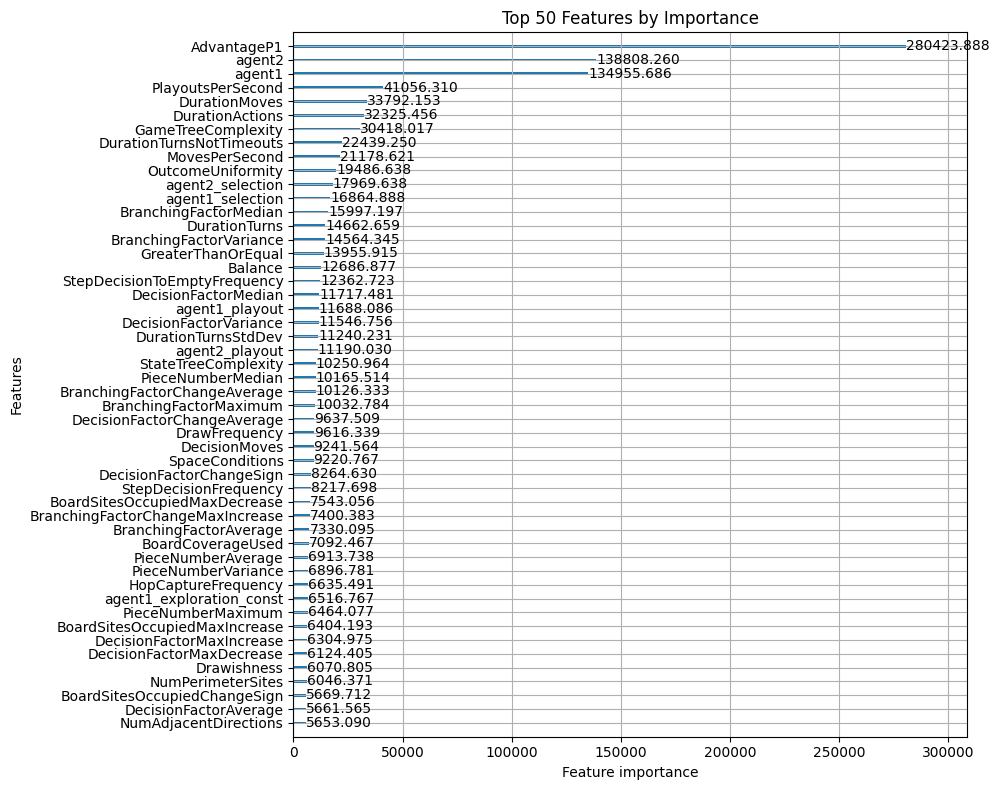

Fold 5 - RMSE: 0.43065626730779294
List of oof scores: [0.4282455830745386, 0.4141171950487219, 0.42348385857974263, 0.41544959342333065, 0.43065626730779294]
Average oof score: 0.4223904994868254


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4238
Score: 0.4511
Score: 0.4372
Score: 0.4358
Score: 0.4064
Average CV1 Score: 0.4309

CV2 OOF Scores:
Score: 0.4134
Score: 0.4043
Score: 0.4346
Score: 0.4404
Score: 0.4318
Average CV2 Score: 0.4249

CV3 OOF Scores:
Score: 0.4282
Score: 0.4141
Score: 0.4235
Score: 0.4154
Score: 0.4307
Average CV3 Score: 0.4224


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

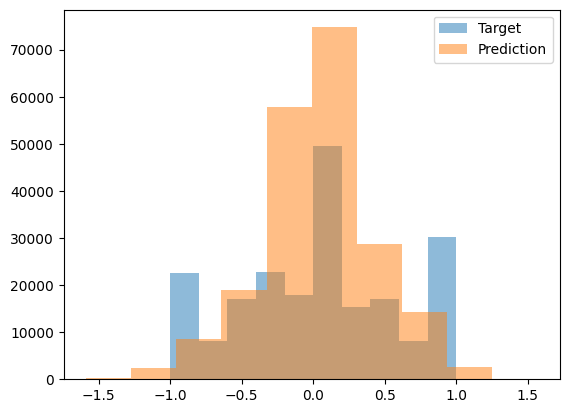

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.136061       │
│ 233235 ┆ -0.187425      │
│ 233236 ┆ -0.024622      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***